In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Collect Data

In [23]:
tickers_names = {"SHEL": "Shell",
                 "XOM": "ExxonMobil",
                 "BP": "BP",
                 "CVX": "Chevron"}

oil_tickers_names = {'CL=F':'Crude Oil',
                     'NG=F':'Natural Gas'}

def FetchStockData(ticker_symbol, company_name):
    ticker = yf.Ticker(ticker_symbol)
    today = datetime.date.today().strftime('%Y-%m-%d')
    data = ticker.history(start="2021-01-01", end=today)
    
    # Reset the index and keep 'Date' as a column
    data.reset_index(inplace=True)
    
    # Ensure the 'Date' column is in the correct format
    if pd.api.types.is_datetime64_any_dtype(data['Date']):
        data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')
    
    # Drop unnecessary columns
    data.drop(columns=['Dividends', 'Stock Splits'], inplace=True, errors='ignore')
    
    # Add additional columns for ticker and commodity
    data['ticker'] = ticker_symbol  
    data['company'] = company_name  
    
    # Convert all column names to lowercase for consistency
    data.columns = [col.lower() for col in data.columns]
    
    # Reorder columns to place 'ticker', 'commodity', and 'date' at the beginning
    data = data[['ticker', 'company', 'date'] + [col for col in data.columns if col not in ['ticker', 'company', 'date']]]
    data['date'] = pd.to_datetime(data['date'])

    return data



# 2. Loop over each symbol and append data to a DataFrame
all_data = []
for symbol, name in tickers_names.items():
    all_data.append(FetchStockData(symbol, name))
for symbol, name in oil_tickers_names.items():
    all_data.append(FetchStockData(symbol, name))
# Concatenate all the individual datasets into one
stock_data = pd.concat(all_data, ignore_index=True)
stock_data.to_csv('data/stock_data.csv', index = False)


# Inspect Data

## General

In [24]:
print("Energy Stock Prices Dataset Info:")
print(stock_data.info())

Energy Stock Prices Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6501 entries, 0 to 6500
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   ticker   6501 non-null   object        
 1   company  6501 non-null   object        
 2   date     6501 non-null   datetime64[ns]
 3   open     6501 non-null   float64       
 4   high     6501 non-null   float64       
 5   low      6501 non-null   float64       
 6   close    6501 non-null   float64       
 7   volume   6501 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 406.4+ KB
None


In [25]:
print("Energy Stock Prices Dataset Description:")
print(stock_data.describe())

Energy Stock Prices Dataset Description:
                                date         open         high          low  \
count                           6501  6501.000000  6501.000000  6501.000000   
mean   2023-02-27 07:38:44.134748672    64.354460    65.094858    63.586944   
min              2021-01-04 00:00:00     1.533000     1.628000     1.481000   
25%              2022-01-28 00:00:00    30.176103    30.478716    29.969689   
50%              2023-02-28 00:00:00    61.636260    62.277704    60.956364   
75%              2024-03-27 00:00:00    94.089996    95.508117    92.790001   
max              2025-04-25 00:00:00   169.405669   171.723328   168.554666   
std                              NaN    45.185558    45.656391    44.685704   

             close        volume  
count  6501.000000  6.501000e+03  
mean     64.348153  7.699289e+06  
min       1.575000  0.000000e+00  
25%      30.273315  3.317090e+05  
50%      61.610809  5.923500e+06  
75%      94.203377  1.129320e+07  
ma

In [26]:
print("The Number of Instances for Each Company:")
print(stock_data['company'].value_counts())

The Number of Instances for Each Company:
company
Natural Gas    1085
Crude Oil      1084
ExxonMobil     1083
Shell          1083
Chevron        1083
BP             1083
Name: count, dtype: int64


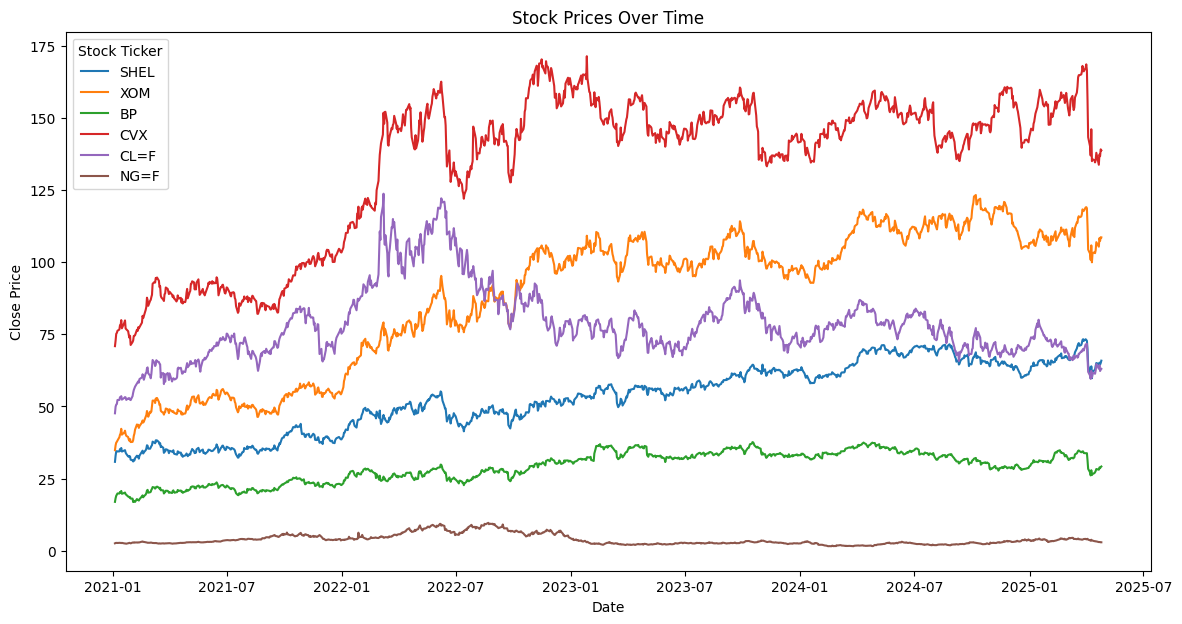

In [27]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=stock_data, x='date', y='close', hue='ticker')
plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(title='Stock Ticker')
plt.savefig("plots/stock_prices_over_time.png", dpi=300, bbox_inches='tight') 
plt.show()

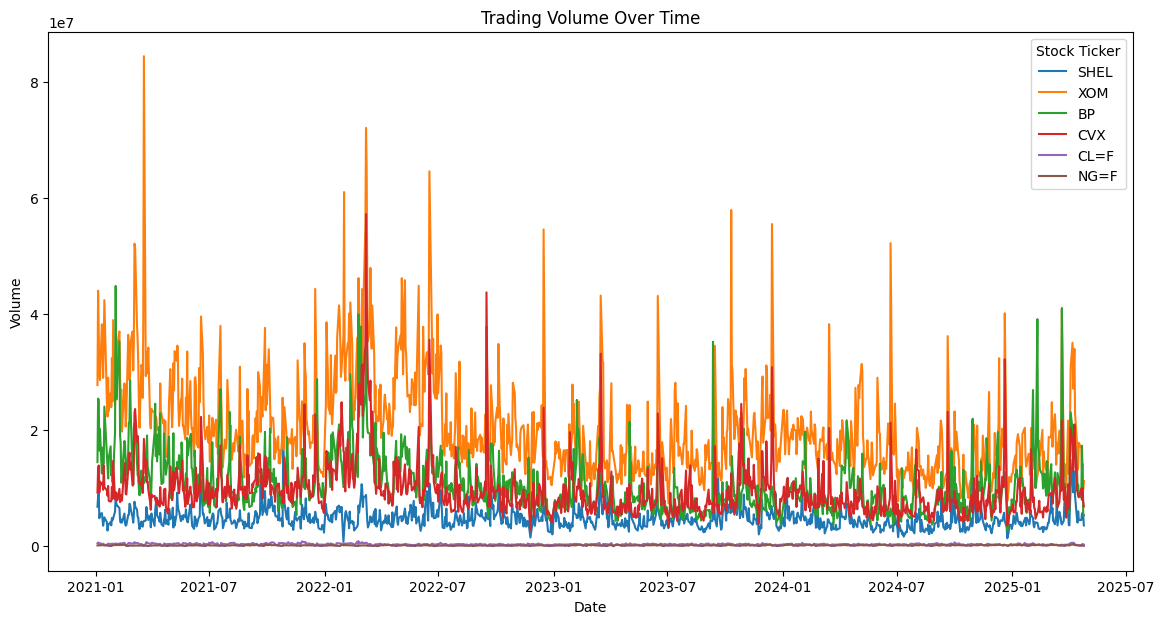

In [28]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=stock_data, x='date', y='volume', hue='ticker')
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend(title='Stock Ticker')
plt.savefig("plots/trading_volume_over_time.png", dpi=300, bbox_inches='tight') 
plt.show()

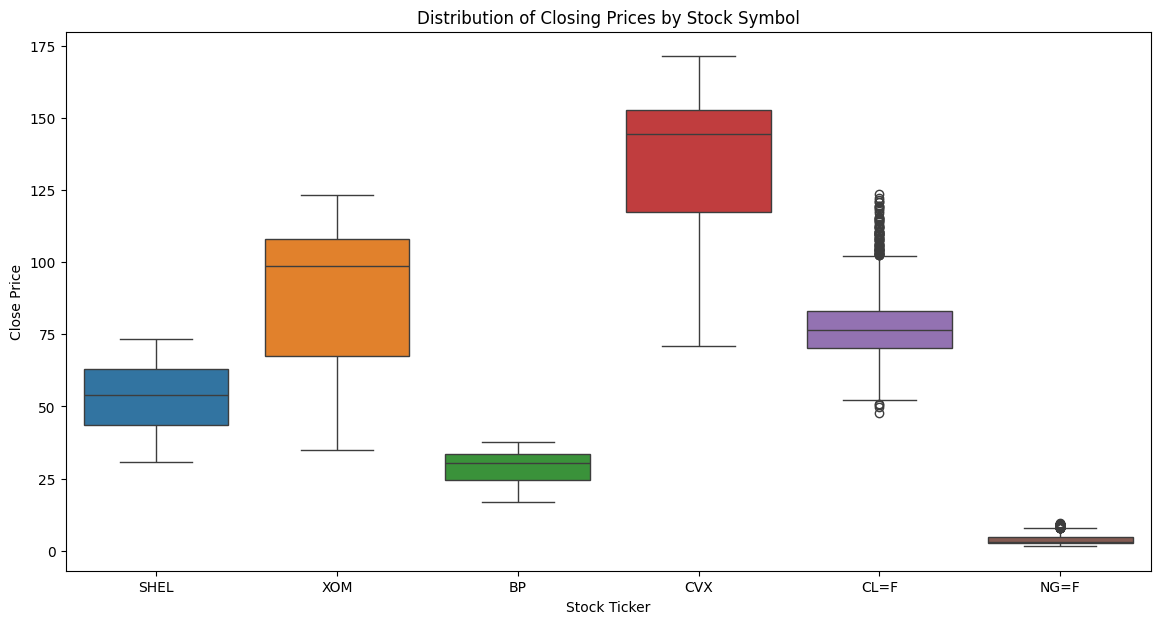

In [29]:
plt.figure(figsize=(14, 7))
sns.boxplot(data=stock_data, x='ticker', y='close', hue='ticker')
plt.title('Distribution of Closing Prices by Stock Symbol')
plt.xlabel('Stock Ticker')
plt.ylabel('Close Price')
plt.savefig("plots/distribution_of_closing_prices_by_stock_symbol.png", dpi=300, bbox_inches='tight') 
plt.show()

In [30]:
# pivot_table = stock_data.pivot(index='date', columns='ticker', values='close')
# pivot_table

pivot_table = stock_data.reset_index().pivot(index='date', columns='ticker', values='close')
pivot_table


ticker             BP       CL=F         CVX   NG=F       SHEL         XOM
date                                                                      
2021-01-04  16.946373  47.619999   70.881592  2.581  30.810040   34.851479
2021-01-05  18.207382  49.930000   72.797745  2.702  32.930744   36.531075
2021-01-06  19.045349  50.630001   75.140678  2.716  34.452858   37.463238
2021-01-07  19.452127  50.830002   75.492104  2.729  34.495617   37.757172
2021-01-08  19.850771  52.240002   76.211723  2.700  34.410103   38.177071
...               ...        ...         ...    ...        ...         ...
2025-04-21  28.080000  63.080002  133.729996  3.016  64.650002  105.349998
2025-04-22  28.870001  64.309998  137.300003  3.007  65.169998  108.300003
2025-04-23  28.600000  62.270000  136.679993  3.022  64.510002  107.370003
2025-04-24  29.000000  62.790001  139.070007  2.930  65.050003  108.629997
2025-04-25  29.190001  63.020000  138.729996  2.937  65.860001  108.570000

[1085 rows x 6 columns]

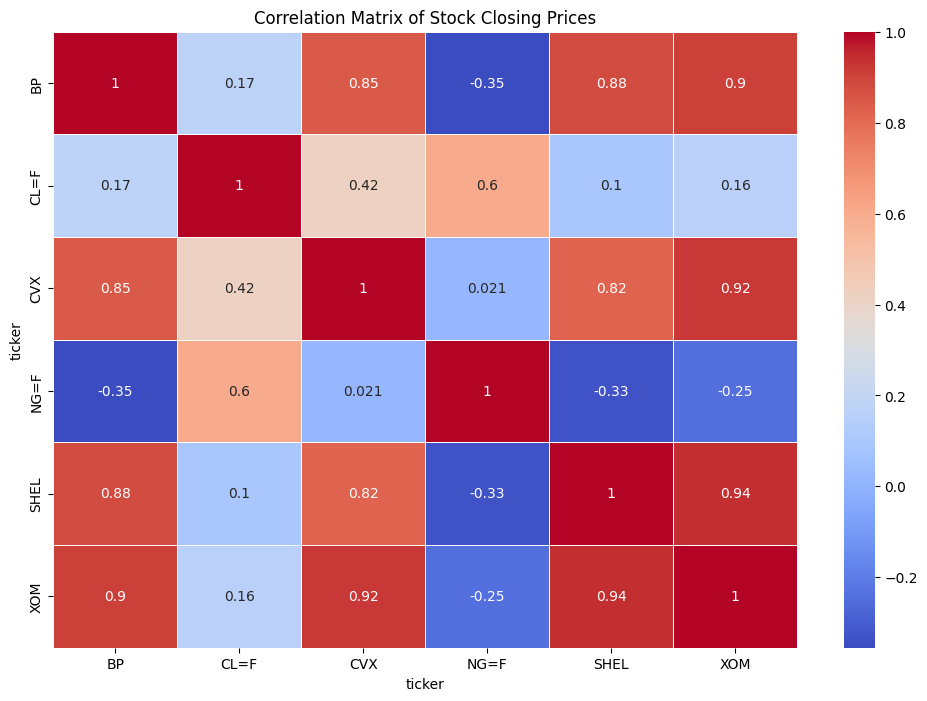

In [31]:
correlation_matrix = pivot_table.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Stock Closing Prices')
plt.savefig("plots/correlation_matrix_of_stock_closing_prices.png", dpi=300, bbox_inches='tight') 
plt.show()

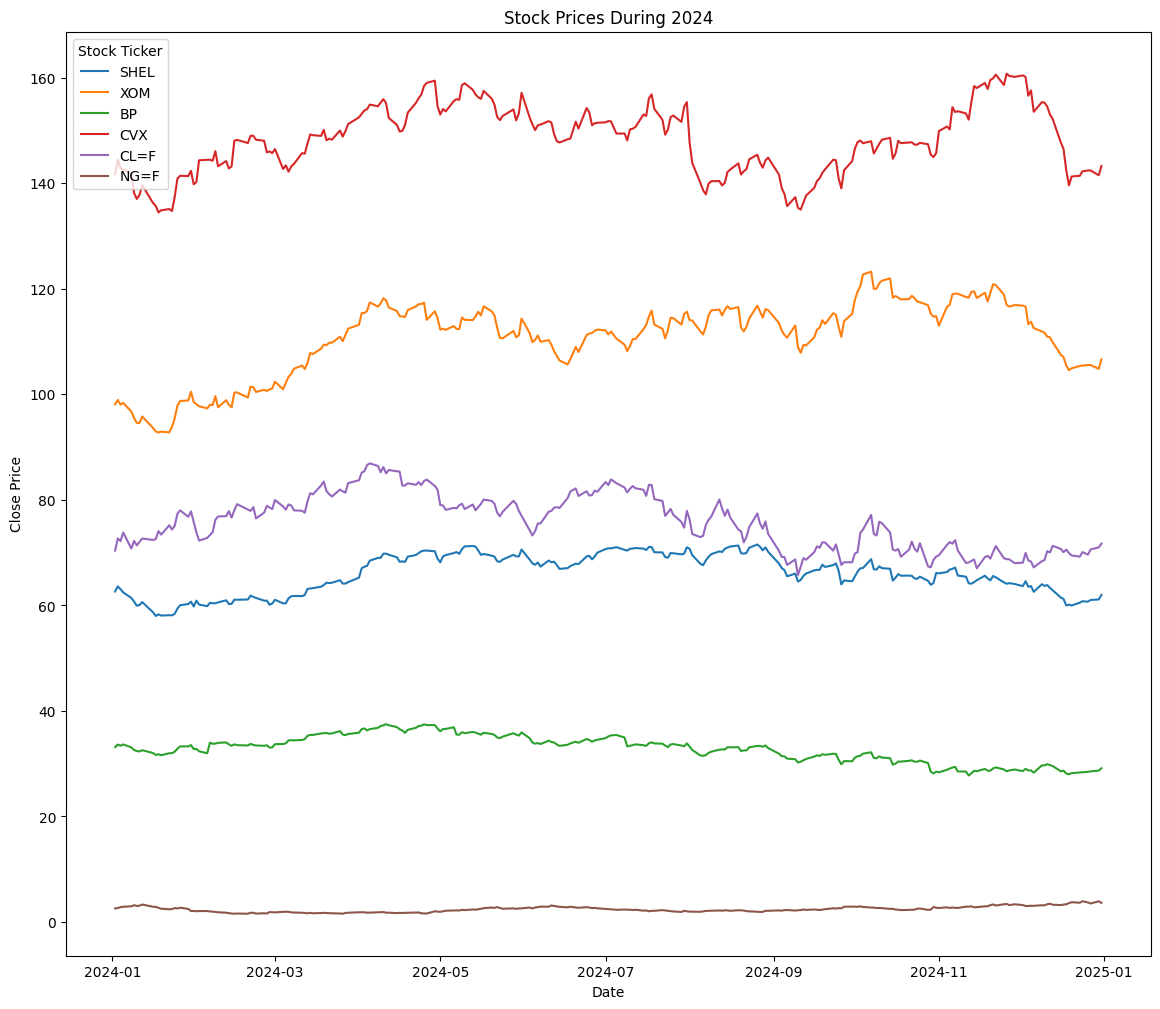

In [32]:
stock_data_2024 = stock_data.reset_index()[(stock_data['date'] >= '2024-01-01') & (stock_data['date'] <= '2024-12-31')]

plt.figure(figsize= (14, 12))
sns.lineplot(data = stock_data_2024, x = 'date', y = 'close', hue = 'ticker')
plt.title('Stock Prices During 2024')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(title = 'Stock Ticker')
plt.savefig("plots/stock_prices_during_2024.png", dpi=300, bbox_inches='tight') 
plt.show()

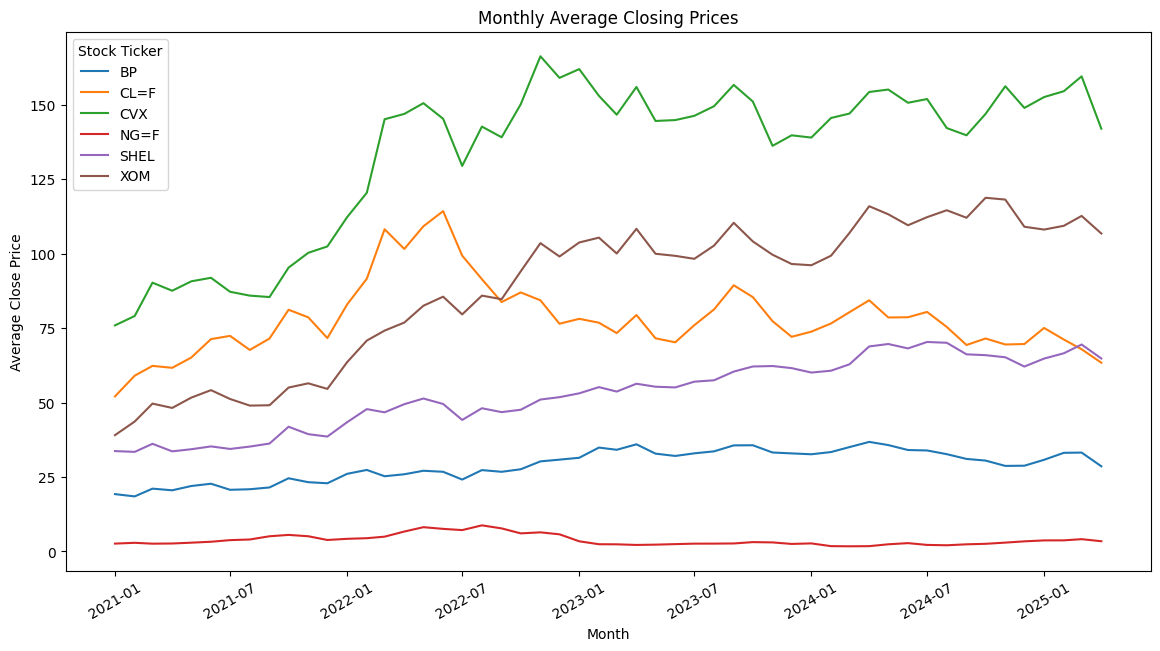

In [33]:
stock_data['month'] = stock_data['date'].dt.to_period('M').dt.to_timestamp()
monthly_avg_prices = stock_data.groupby(['month', 'ticker']).mean(numeric_only=True).reset_index()

plt.figure(figsize = (14, 7))
sns.lineplot(data = monthly_avg_prices, x = 'month', y = 'close', hue = 'ticker')
plt.title('Monthly Average Closing Prices')
plt.xlabel('Month')
plt.ylabel('Average Close Price')
plt.xticks(rotation = 30)
plt.legend(title = 'Stock Ticker')
plt.savefig("plots/monthly_average_closing_prices.png", dpi=300, bbox_inches='tight') 
plt.show()

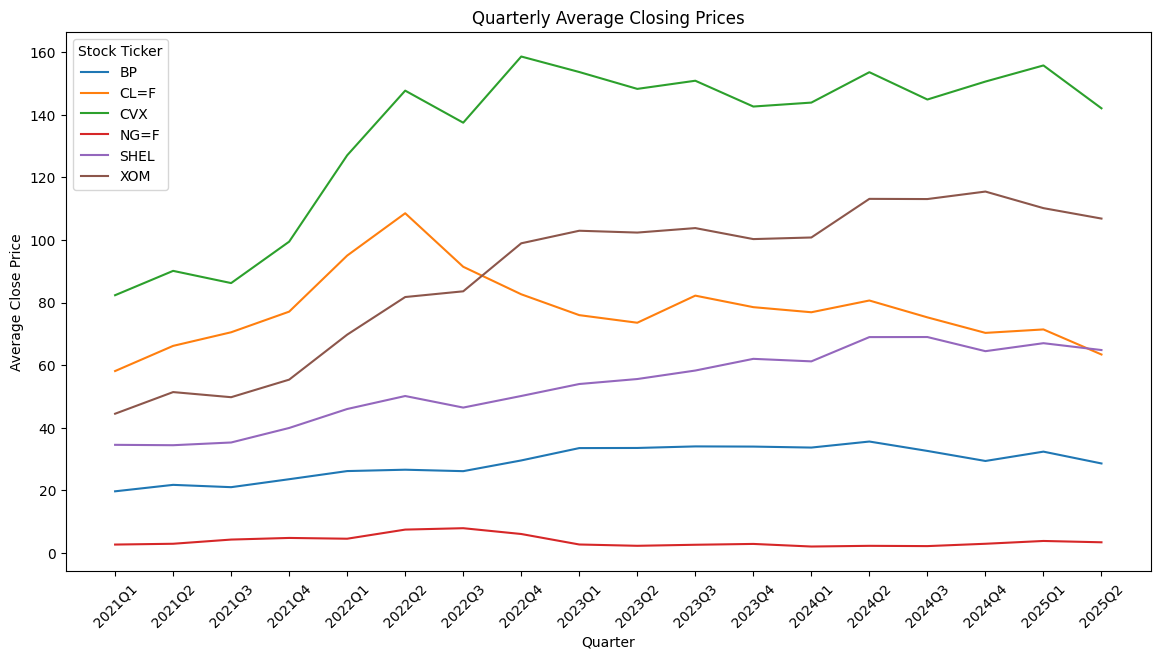

In [34]:
stock_data['quarter'] = stock_data['date'].dt.to_period('Q')
quarterly_avg_prices = stock_data.groupby(['quarter', 'ticker']).mean(numeric_only=True).reset_index()
quarterly_avg_prices['quarter'] = quarterly_avg_prices['quarter'].astype(str)

plt.figure(figsize = (14, 7))
sns.lineplot(data = quarterly_avg_prices, x = 'quarter', y = 'close', hue = 'ticker')
plt.title('Quarterly Average Closing Prices')
plt.xlabel('Quarter')
plt.ylabel('Average Close Price')
plt.xticks(rotation = 45)
plt.legend(title = 'Stock Ticker')
plt.savefig("plots/quarterly_average_closing_prices.png", dpi=300, bbox_inches='tight') 
plt.show()

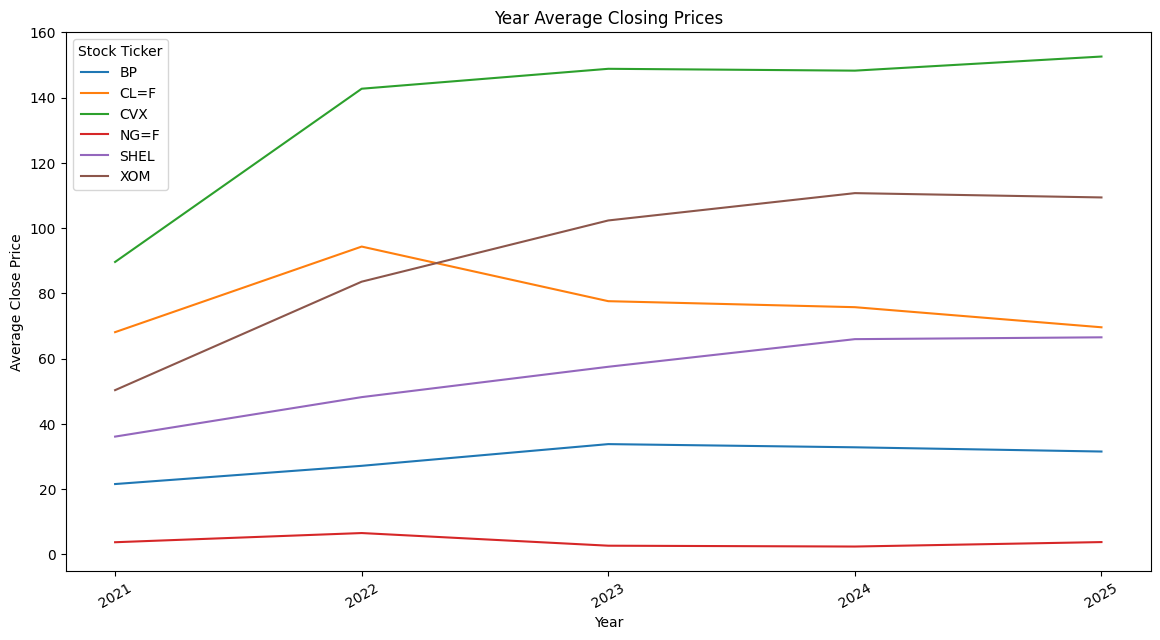

In [35]:
stock_data['year'] = stock_data['date'].dt.year
yearly_avg_prices = stock_data.groupby(['year', 'ticker']).mean(numeric_only=True).reset_index()
yearly_avg_prices['year'] = yearly_avg_prices['year'].astype(int)

plt.figure(figsize = (14, 7))
sns.lineplot(data = yearly_avg_prices, x = 'year', y = 'close', hue = 'ticker')
plt.title('Year Average Closing Prices')
plt.xlabel('Year')
plt.ylabel('Average Close Price')
plt.xticks(ticks=yearly_avg_prices['year'].unique(), rotation=30)
plt.legend(title = 'Stock Ticker')
plt.savefig("plots/year_average_closing_prices.png", dpi=300, bbox_inches='tight') 
plt.show()

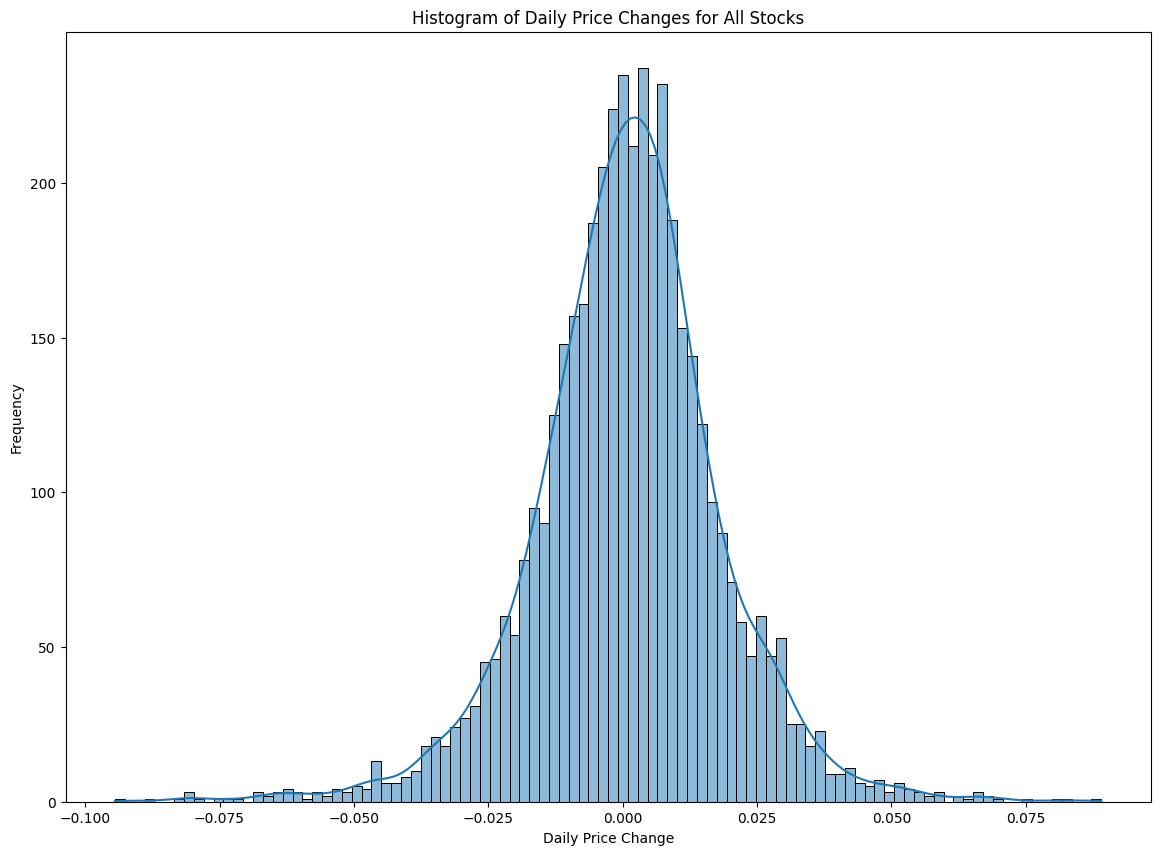

In [36]:
stock_data['price_change'] = stock_data[~stock_data['ticker'].isin(['CL=F','NG=F'])].groupby('ticker')['close'].pct_change() # percentage change

plt.figure(figsize = (14, 10))

sns.histplot(stock_data['price_change'].dropna(), bins = 100, kde = True)
plt.title('Histogram of Daily Price Changes for All Stocks')
plt.xlabel('Daily Price Change')
plt.ylabel('Frequency')
plt.savefig("plots/histogram_of_daily_price_changes_for_all_stocks.png", dpi=300, bbox_inches='tight') 
plt.show()

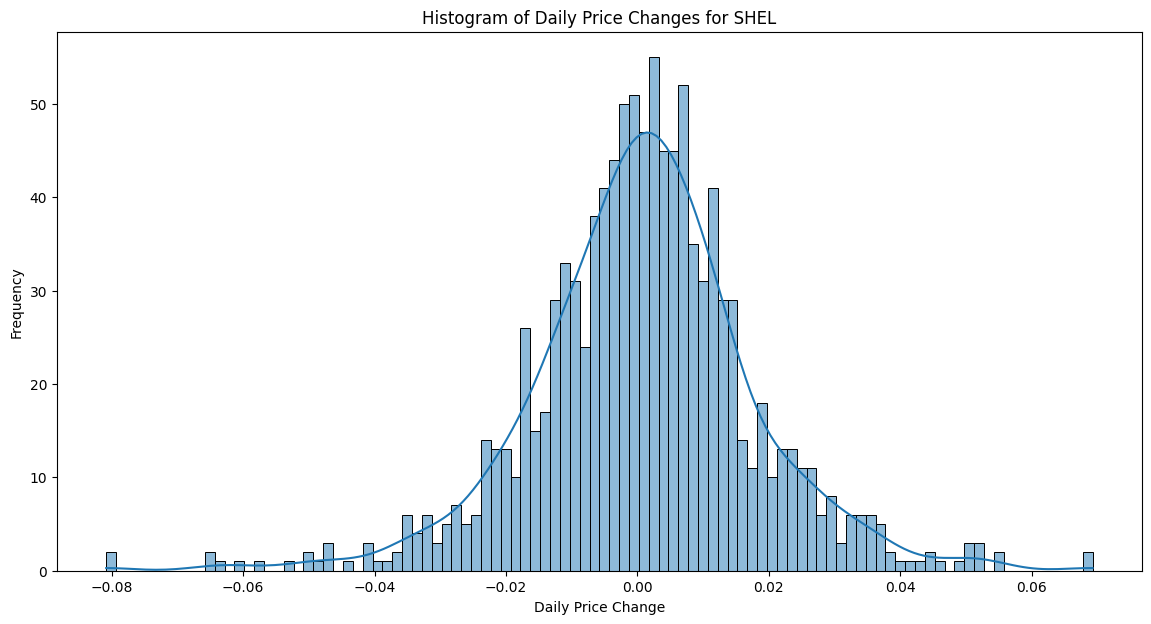

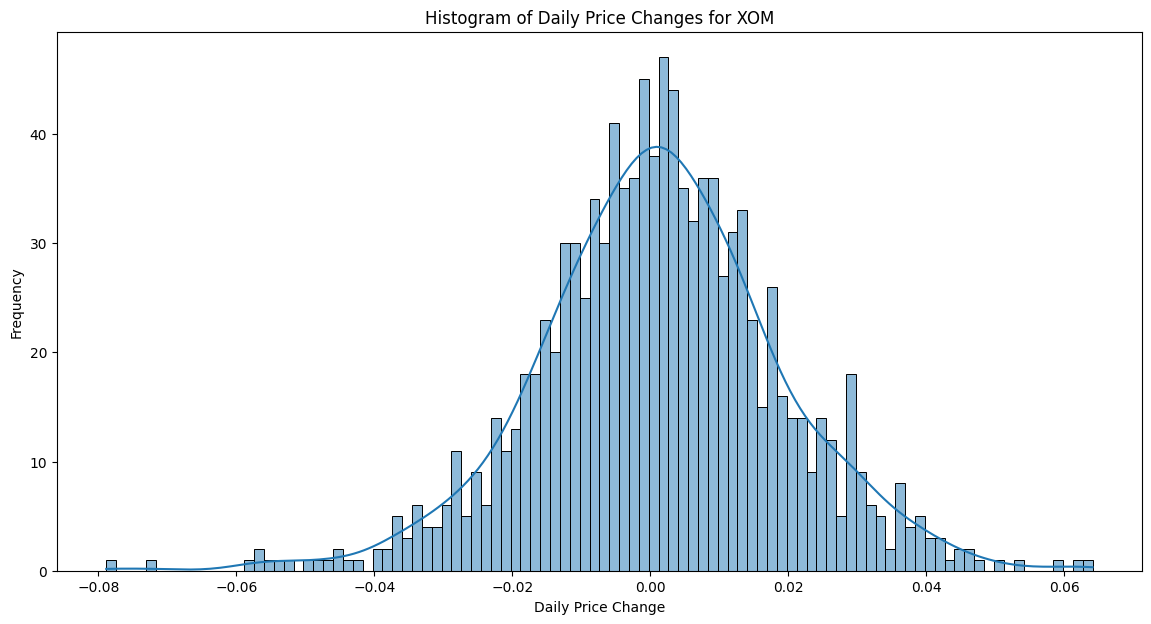

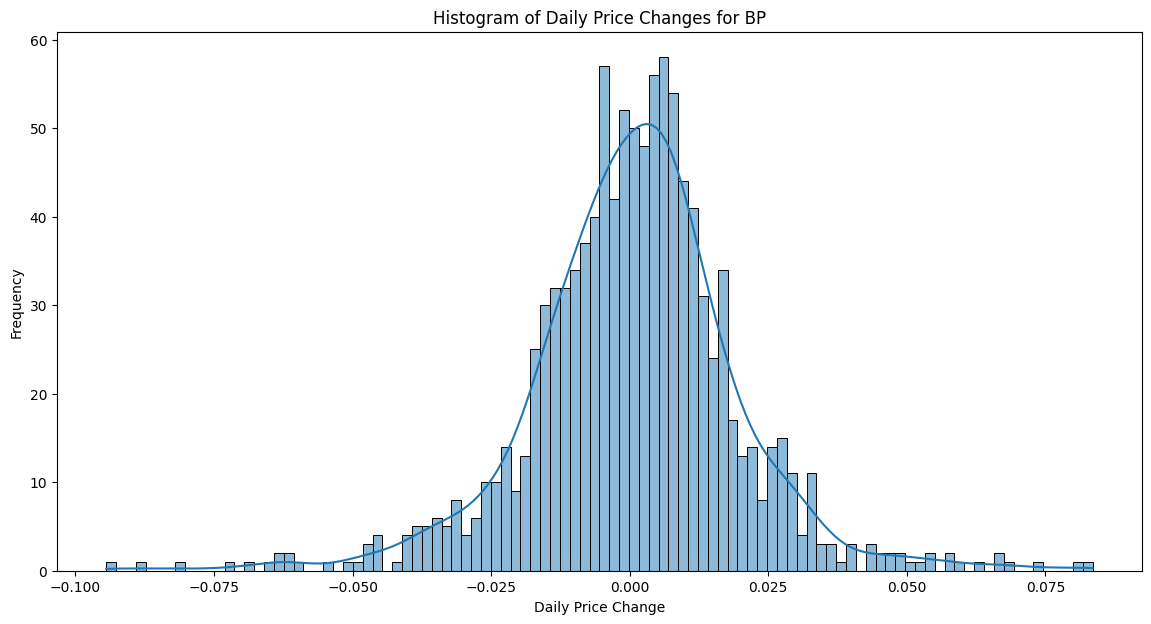

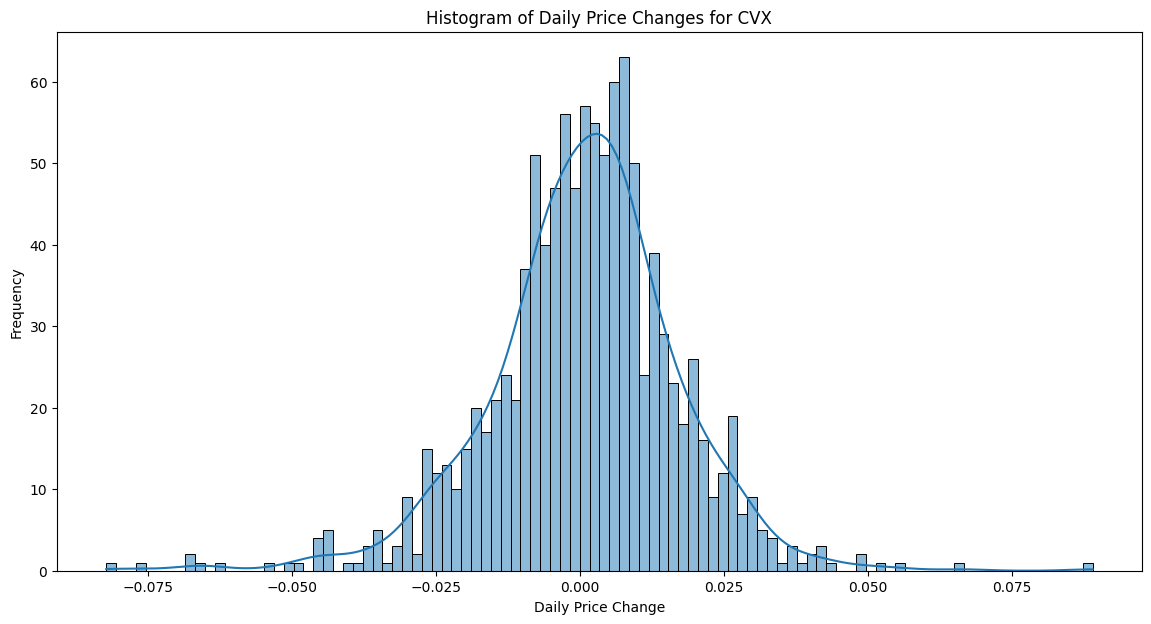

In [37]:
unique_tickers = list(tickers_names.keys())

for t in unique_tickers:
    plt.figure(figsize = (14, 7))
    sns.histplot(stock_data[stock_data['ticker'] == t]['price_change'].dropna(), bins = 100, kde = True)
    plt.title(f"Histogram of Daily Price Changes for {t}")
    plt.xlabel('Daily Price Change')
    plt.ylabel('Frequency')
    plt.savefig(f"plots/histogram_of_daily_price_changes_for_{t}.png", dpi=300, bbox_inches='tight') 
    plt.show()

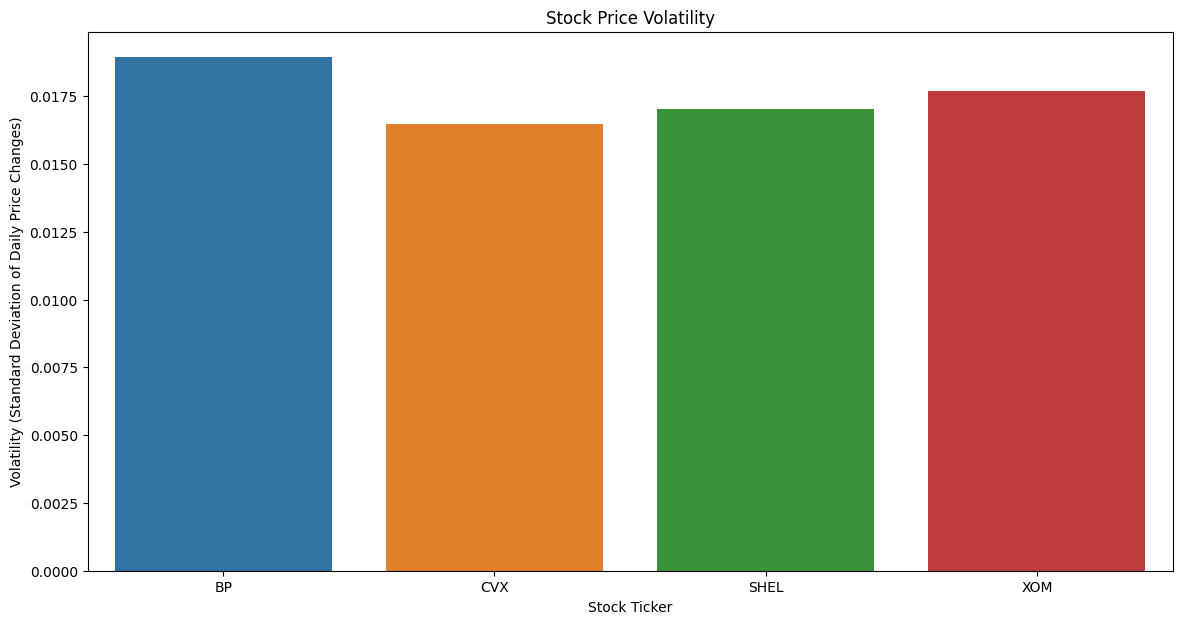

In [38]:
volatility = stock_data[~stock_data['ticker'].isin(['CL=F','NG=F'])].groupby('ticker')['price_change'].std().reset_index()
volatility.columns = ['ticker', 'volatility']

plt.figure(figsize = (14, 7))
sns.barplot(data = volatility, x = 'ticker', y = 'volatility', hue = 'ticker')
plt.title('Stock Price Volatility')
plt.xlabel('Stock Ticker')
plt.ylabel('Volatility (Standard Deviation of Daily Price Changes)')
plt.savefig("plots/stock_price_volatility.png", dpi=300, bbox_inches='tight') 
plt.show()

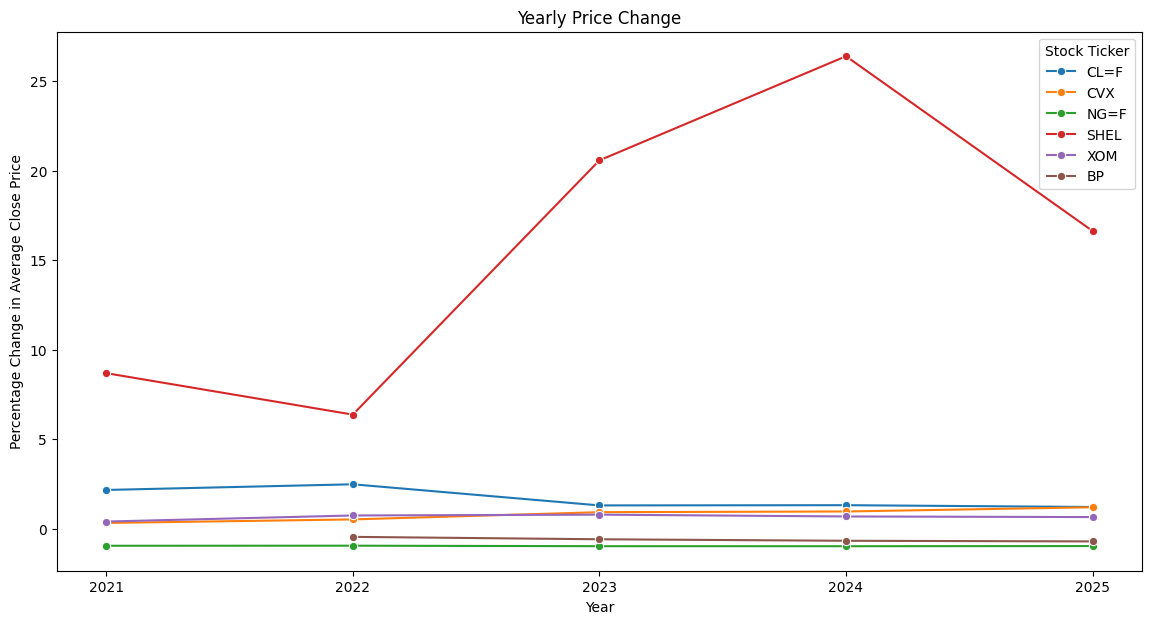

In [39]:
yearly_price_change = stock_data.groupby(['year', 'ticker'])['close'].mean().pct_change().reset_index()
yearly_price_change = yearly_price_change.dropna()

plt.figure(figsize=(14, 7))
sns.lineplot(data = yearly_price_change, x = 'year', y = 'close', hue = 'ticker', marker='o')
plt.title('Yearly Price Change')
plt.xlabel('Year')
plt.ylabel('Percentage Change in Average Close Price')
plt.xticks(ticks=yearly_price_change['year'].unique()) # Display integer instead of decimal number as year
plt.legend(title = 'Stock Ticker')
plt.savefig("plots/yearly_price_change.png", dpi=300, bbox_inches='tight') 
plt.show()

## Shell

In [40]:
shell_stock = stock_data[stock_data['ticker'] == 'SHEL']
shell_stock.set_index('date', inplace = True)

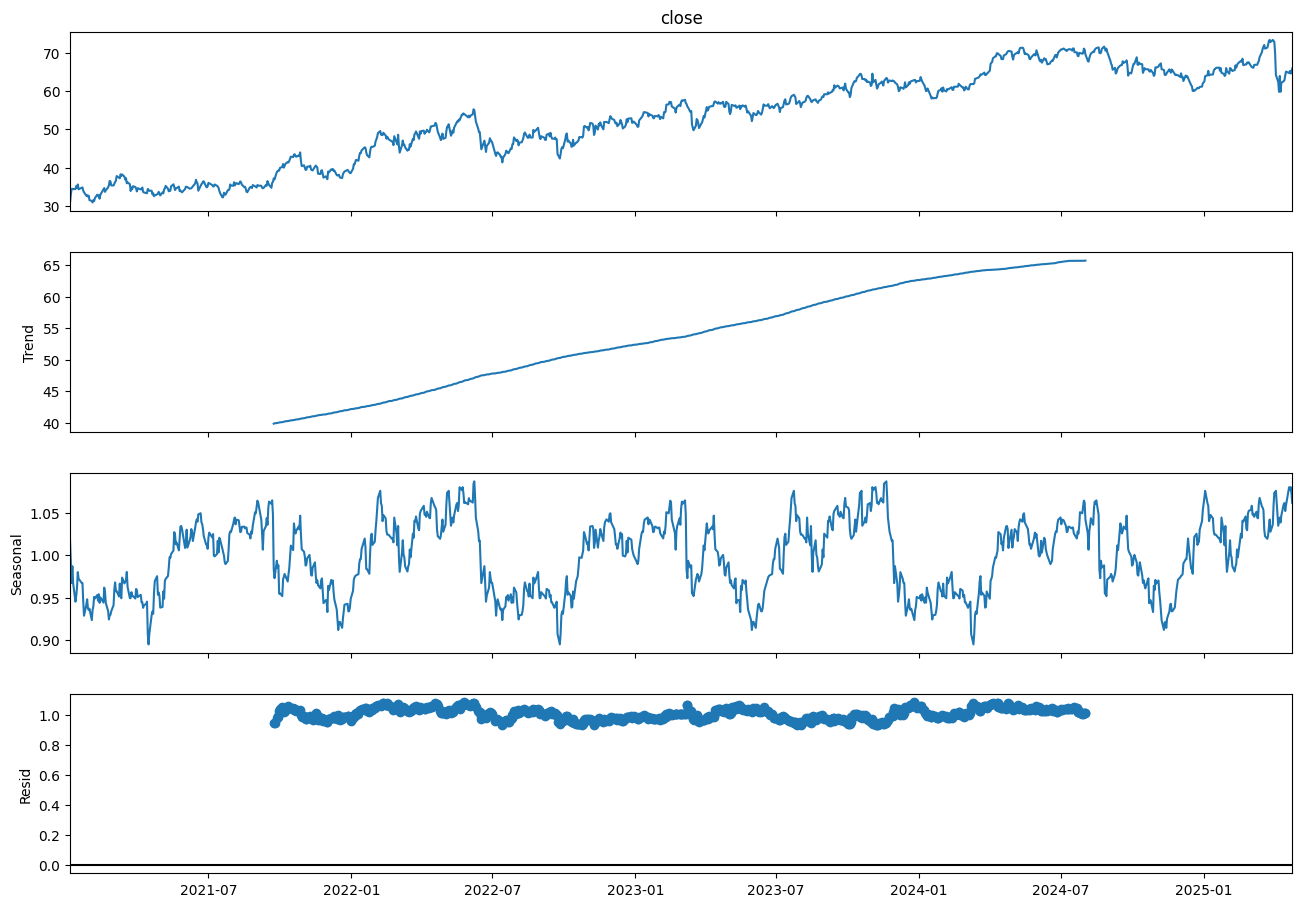

In [41]:
decomposition = seasonal_decompose(shell_stock['close'], model = 'multiplicative', period = 365)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

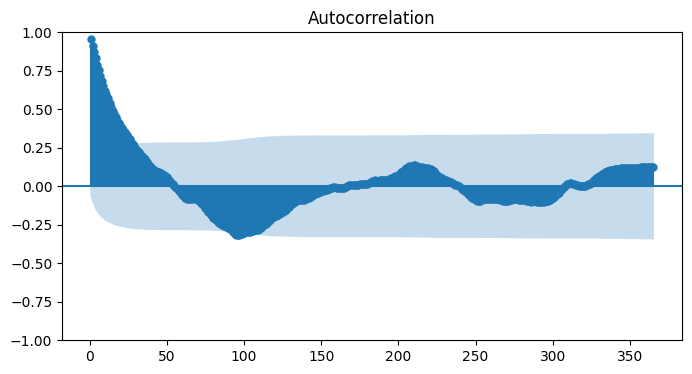

In [62]:
# Subtract long rolling average
detrend = shell_stock['close'] - shell_stock['close'].rolling(90).mean()

# Create figure
fig, ax = plt.subplots(1,1, figsize=(8,4))
# Plot ACF
plot_acf(detrend.dropna(), ax=ax, lags=365, zero=False)
plt.show()

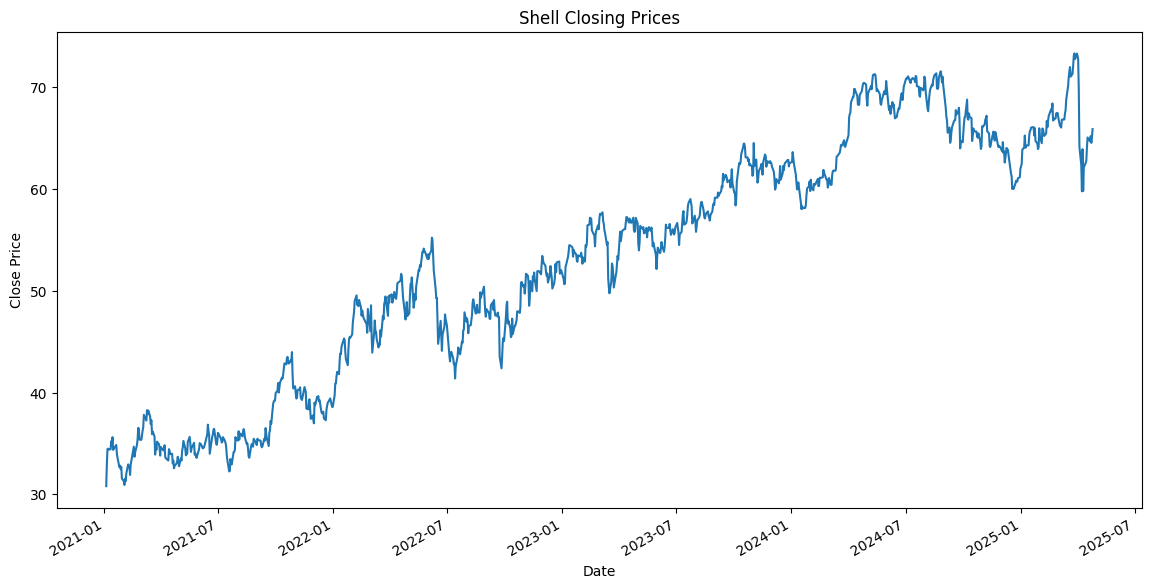

In [43]:
plt.figure(figsize=(14, 7))
shell_stock['close'].plot()
plt.title("Shell Closing Prices")
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

C:\Users\Ying\AppData\Local\Temp\ipykernel_6056\1717016293.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shell_stock['rolling_mean'] = shell_stock['close'].rolling(window = 30).mean()


<Figure size 1400x700 with 0 Axes>

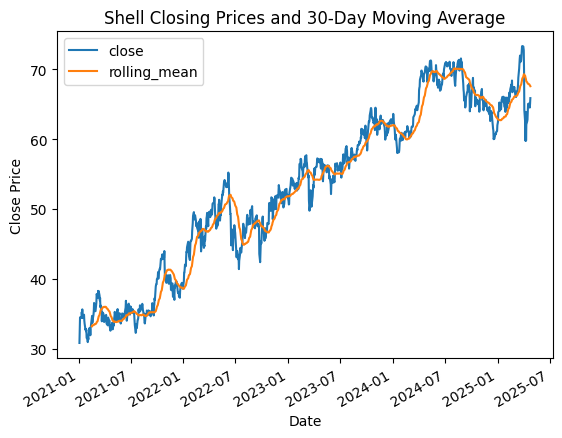

In [ ]:
shell_stock['rolling_mean'] = shell_stock['close'].rolling(window = 30).mean()

plt.figure(figsize=(14, 7))
shell_stock[['close', 'rolling_mean']].plot()
plt.title('Shell Closing Prices and 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

## Chevron

In [45]:
cvx_stock = stock_data[stock_data['ticker'] == 'CVX']
cvx_stock.set_index('date', inplace = True)

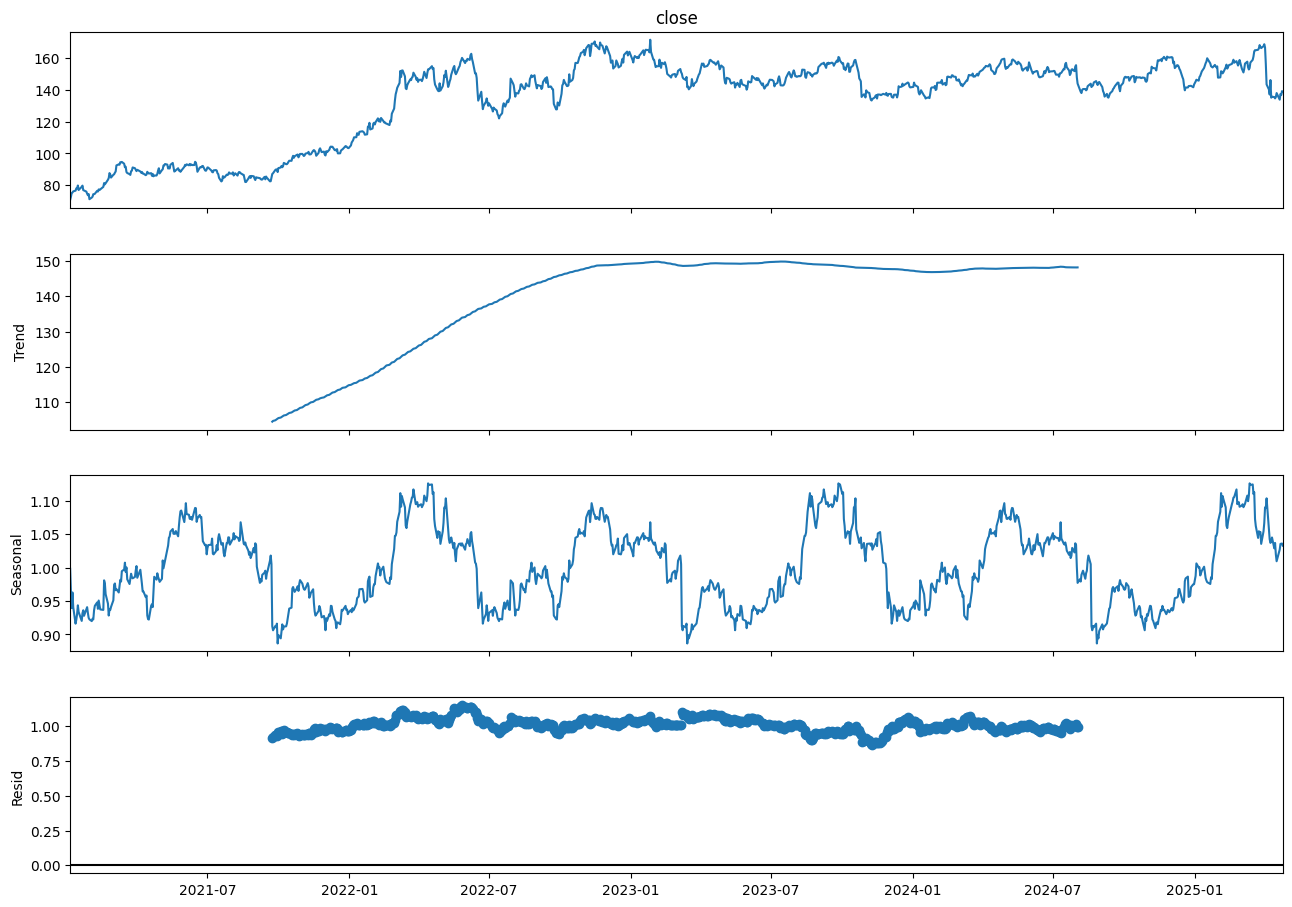

In [46]:
decomposition = seasonal_decompose(cvx_stock['close'], model = 'multiplicative', period = 365)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

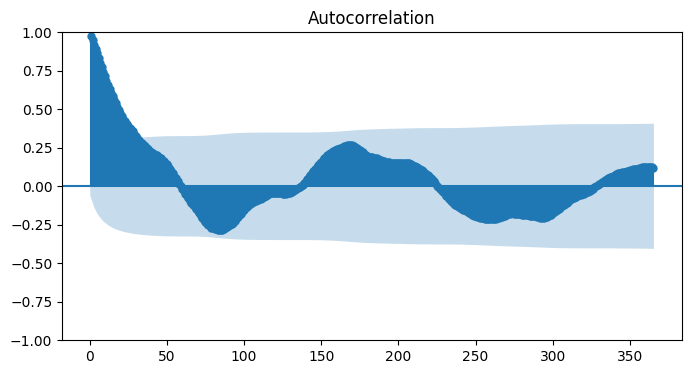

In [60]:
# Subtract long rolling average
detrend = cvx_stock['close'] - cvx_stock['close'].rolling(90).mean()

# Create figure
fig, ax = plt.subplots(1,1, figsize=(8,4))
# Plot ACF
plot_acf(detrend.dropna(), ax=ax, lags=365, zero=False)
plt.show()

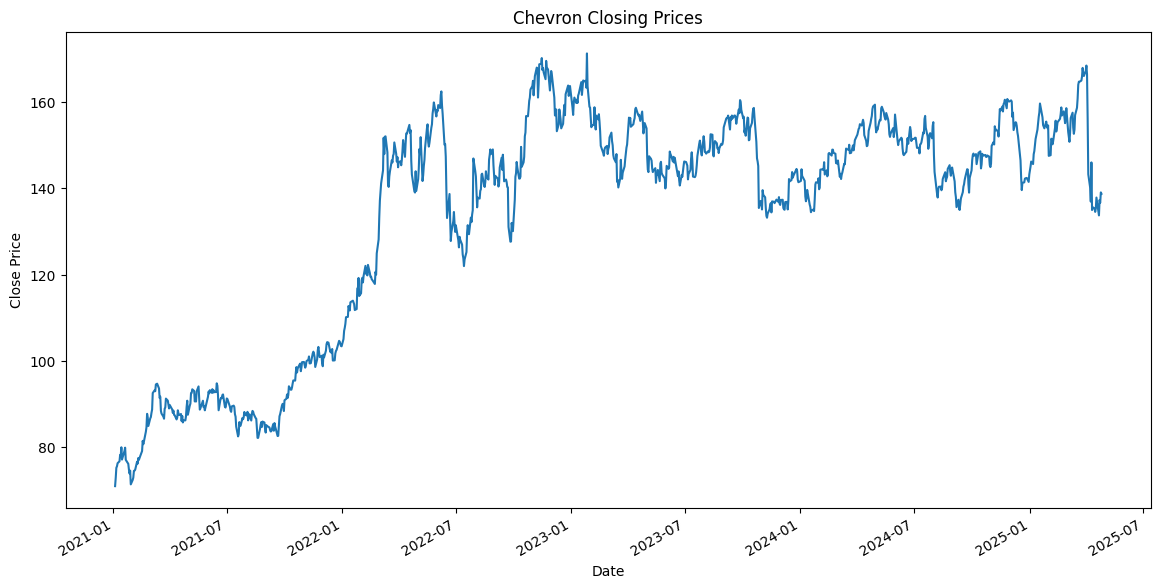

In [48]:
plt.figure(figsize = (14, 7))
cvx_stock['close'].plot()
plt.title('Chevron Closing Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

C:\Users\Ying\AppData\Local\Temp\ipykernel_6056\1352409153.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cvx_stock['rolling_mean'] = cvx_stock['close'].rolling(window = 30).mean()


<Figure size 1400x700 with 0 Axes>

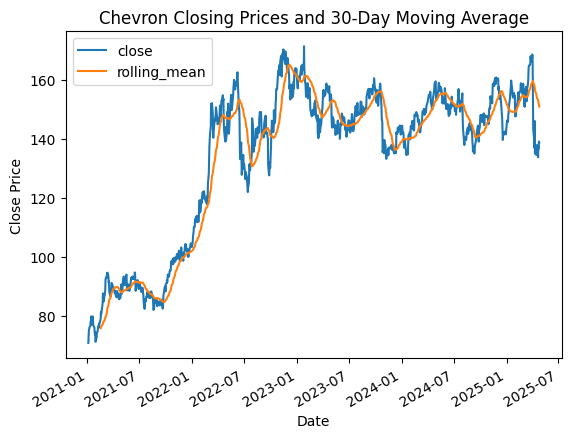

In [49]:
cvx_stock['rolling_mean'] = cvx_stock['close'].rolling(window = 30).mean()

plt.figure(figsize = (14, 7))
cvx_stock[['close', 'rolling_mean']].plot()
plt.title('Chevron Closing Prices and 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

# ADF Test & PACF Plot & ACF Plot

adf test_p-value when d = 0: 0.44118839127995396
adf test_p-value when d = 1: 0.0
Final d = 1


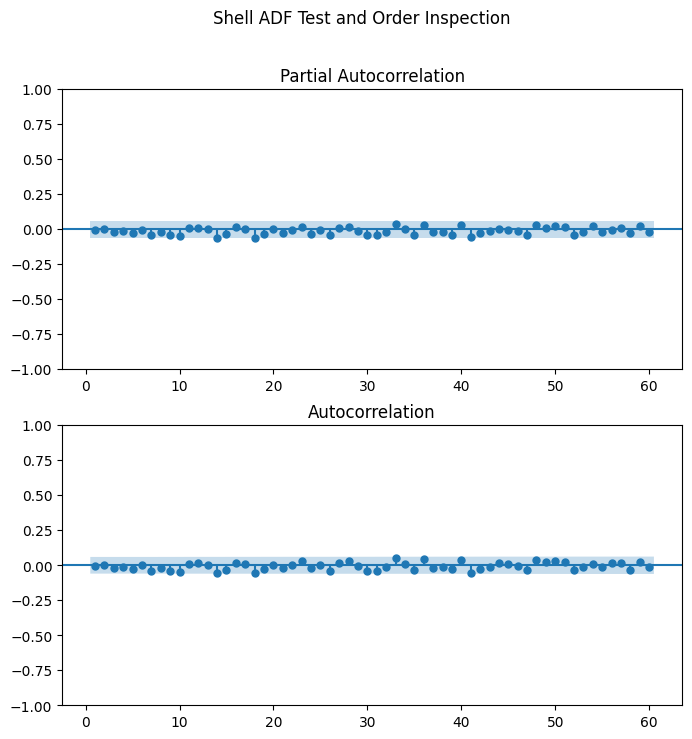

adf test_p-value when d = 0: 0.26749292942371006
adf test_p-value when d = 1: 0.0
Final d = 1


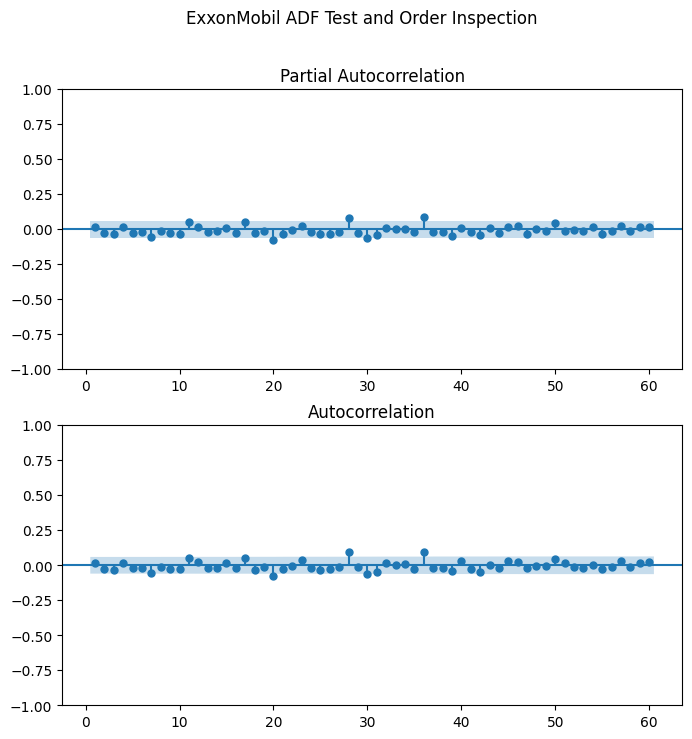

adf test_p-value when d = 0: 0.15321492101833667
adf test_p-value when d = 1: 0.0
Final d = 1


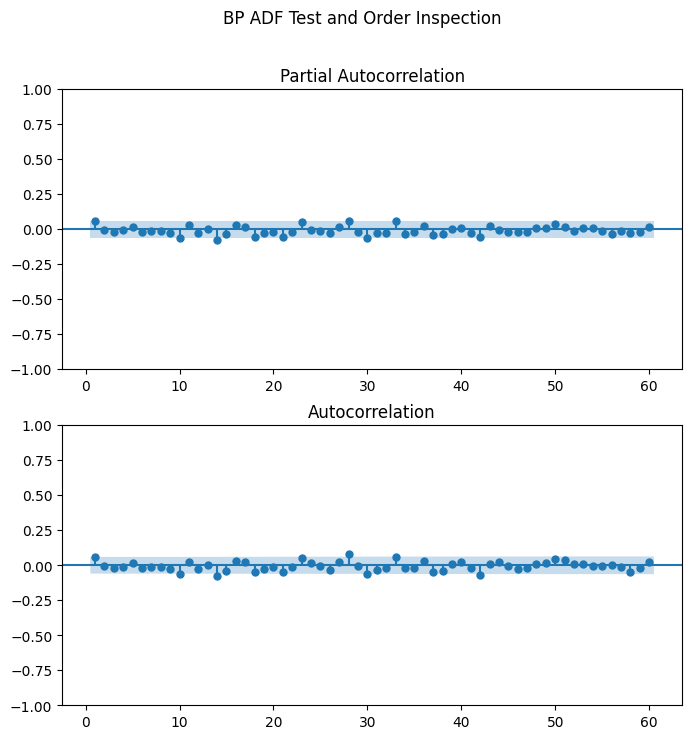

adf test_p-value when d = 0: 0.1487378371247871
adf test_p-value when d = 1: 0.0
Final d = 1


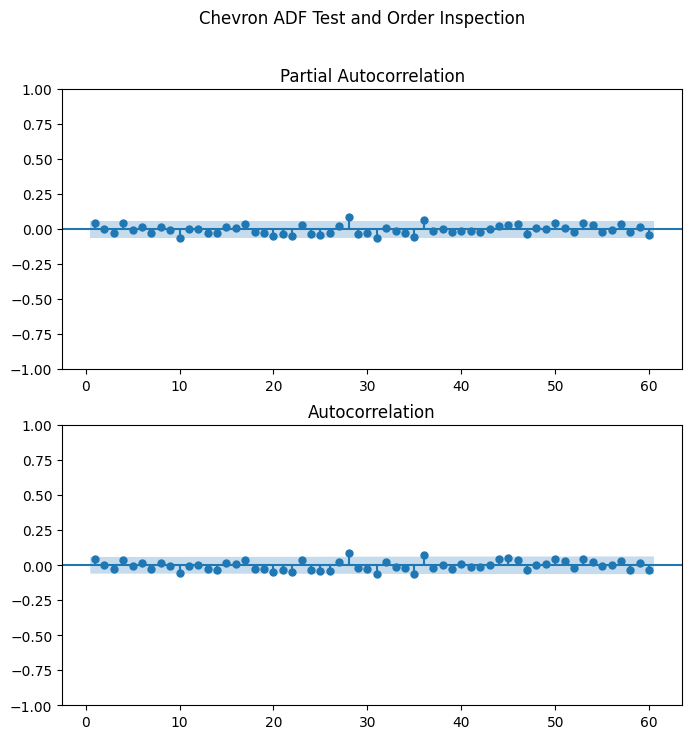

In [50]:
stock_data.set_index('date', inplace = True)

for ticker in list(tickers_names.keys()):
    df = stock_data[stock_data['ticker'] == ticker]['close']
    adf_result = adfuller(df)[1]
    d = 0
    print(f"adf test_p-value when d = {d}: {adf_result}")
    while adf_result >= 0.05 and d < 2:
        df = df.diff().dropna()
        d += 1
        adf_result = adfuller(df)[1]
        print(f"adf test_p-value when d = {d}: {adf_result}")
    print(f"Final d = {d}")
    fig,(ax1, ax2) = plt.subplots(2, 1, figsize = (8,8))
    fig.suptitle(f"{tickers_names[ticker]} ADF Test and Order Inspection")
    ax1.set_title('PACF')
    ax2.set_title('ACF')
    plot_pacf(df, lags = 60, zero = False, ax = ax1)
    plot_acf(df, lags = 60, zero = False, ax = ax2)
    plt.show()
    

# Prediction

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1083
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1362.437
Date:                Mon, 28 Apr 2025   AIC                           2726.873
Time:                        13:30:06   BIC                           2731.860
Sample:                             0   HQIC                          2728.761
                               - 1083                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.7265      0.019     38.932      0.000       0.690       0.763
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               673.87
Prob(Q):                              0.92   Pr

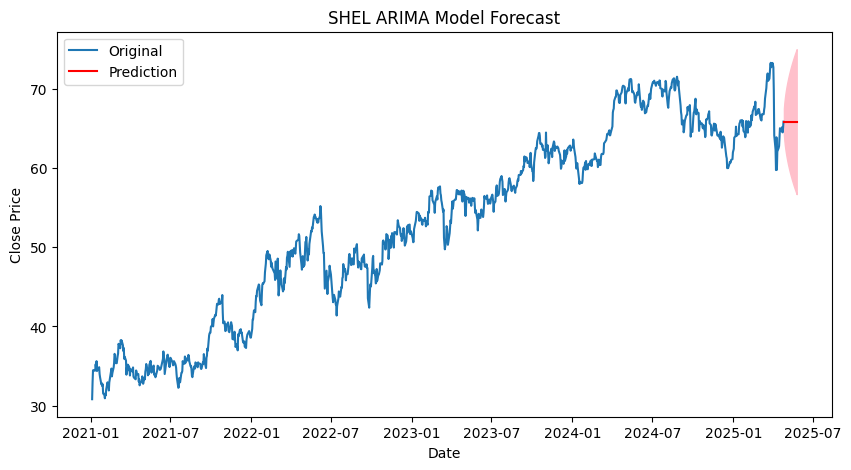

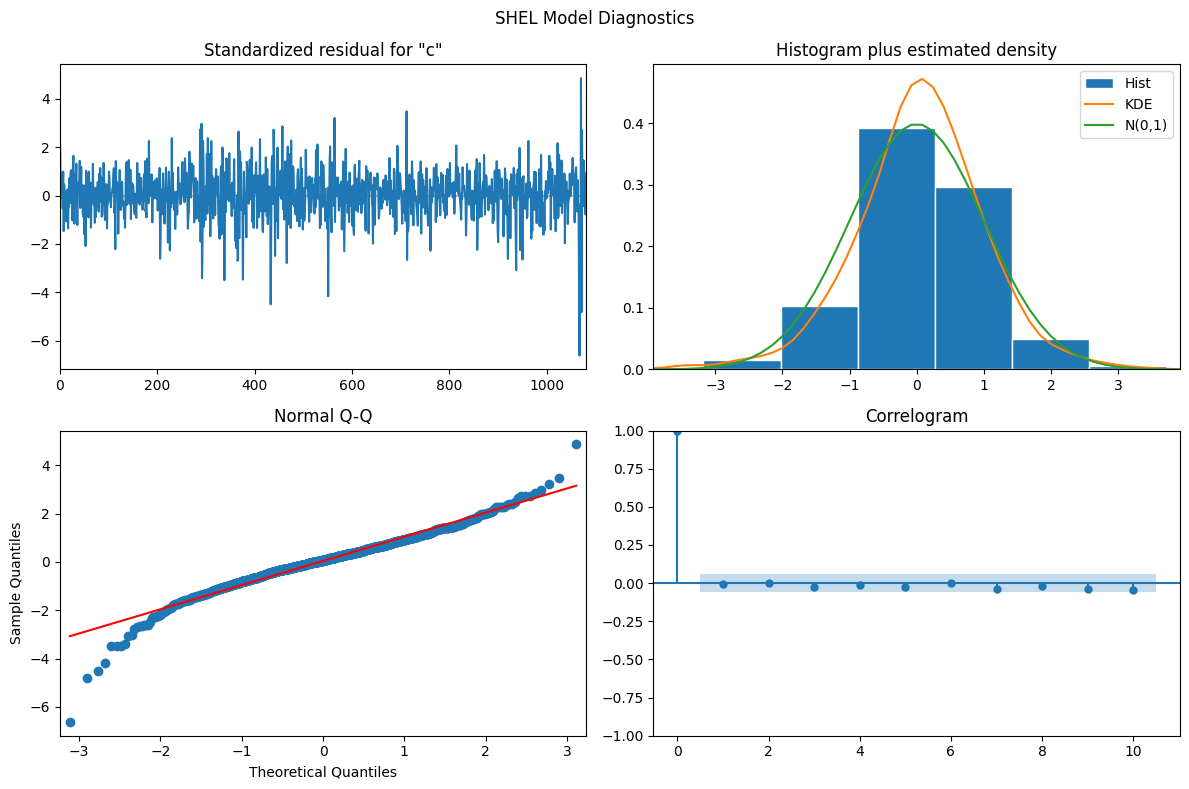

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1083
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1989.004
Date:                Mon, 28 Apr 2025   AIC                           3980.008
Time:                        13:30:07   BIC                           3984.994
Sample:                             0   HQIC                          3981.896
                               - 1083                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.3132      0.072     32.337      0.000       2.173       2.453
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):               194.78
Prob(Q):                              0.57   Pr

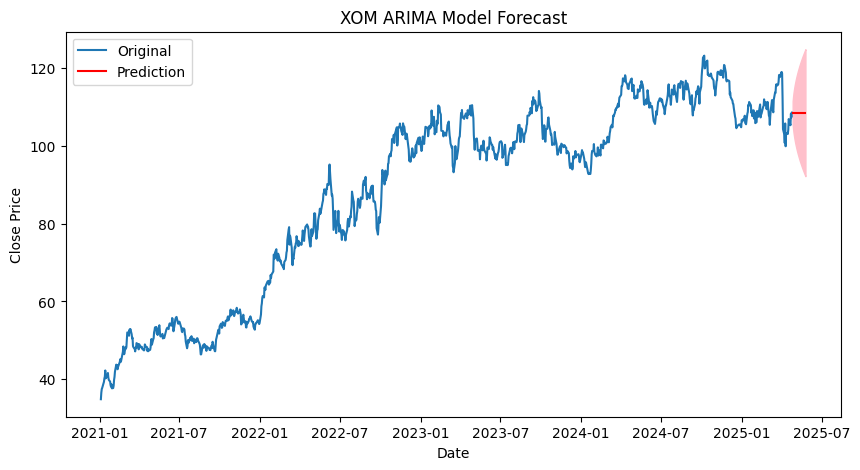

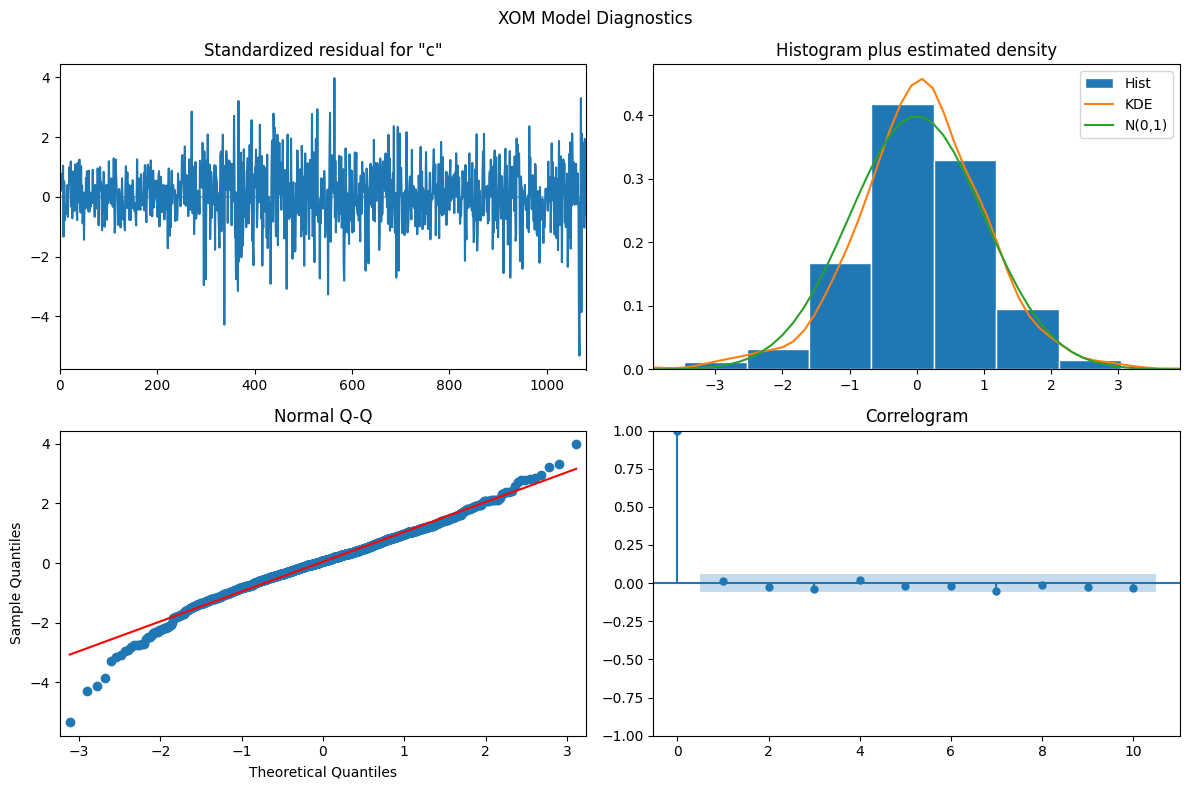

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1083
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -832.662
Date:                Mon, 28 Apr 2025   AIC                           1667.324
Time:                        13:30:08   BIC                           1672.311
Sample:                             0   HQIC                          1669.212
                               - 1083                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2729      0.007     40.343      0.000       0.260       0.286
Ljung-Box (L1) (Q):                   3.64   Jarque-Bera (JB):               788.31
Prob(Q):                              0.06   Pr

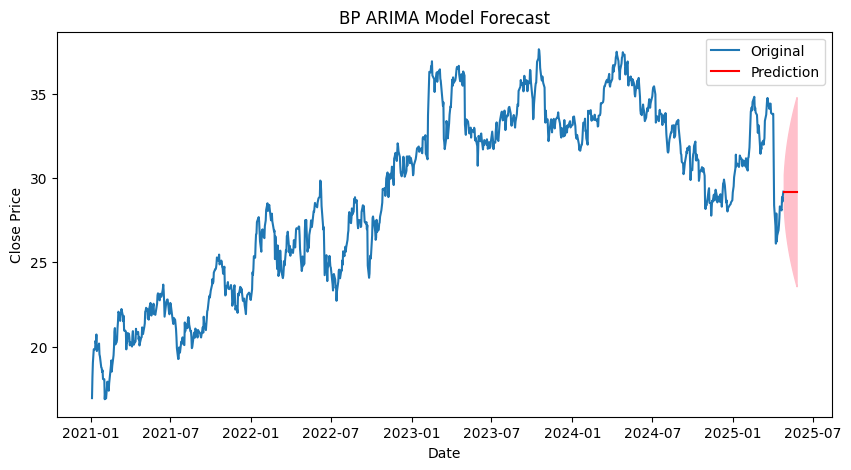

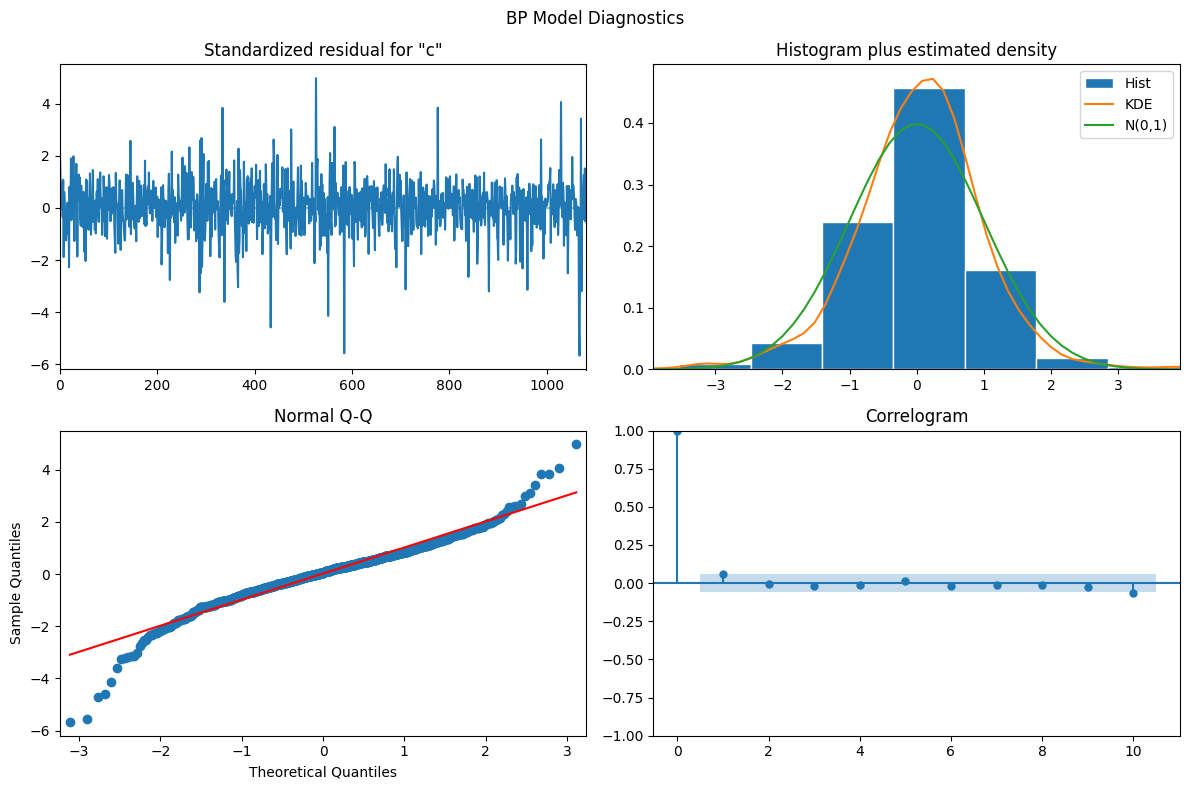

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1083
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2413.205
Date:                Mon, 28 Apr 2025   AIC                           4828.409
Time:                        13:30:09   BIC                           4833.396
Sample:                             0   HQIC                          4830.297
                               - 1083                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         5.0670      0.126     40.246      0.000       4.820       5.314
Ljung-Box (L1) (Q):                   2.08   Jarque-Bera (JB):               809.55
Prob(Q):                              0.15   Pr

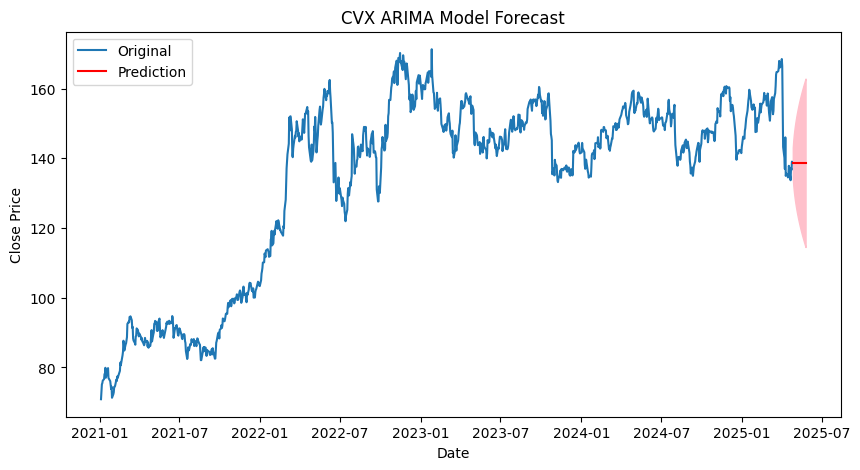

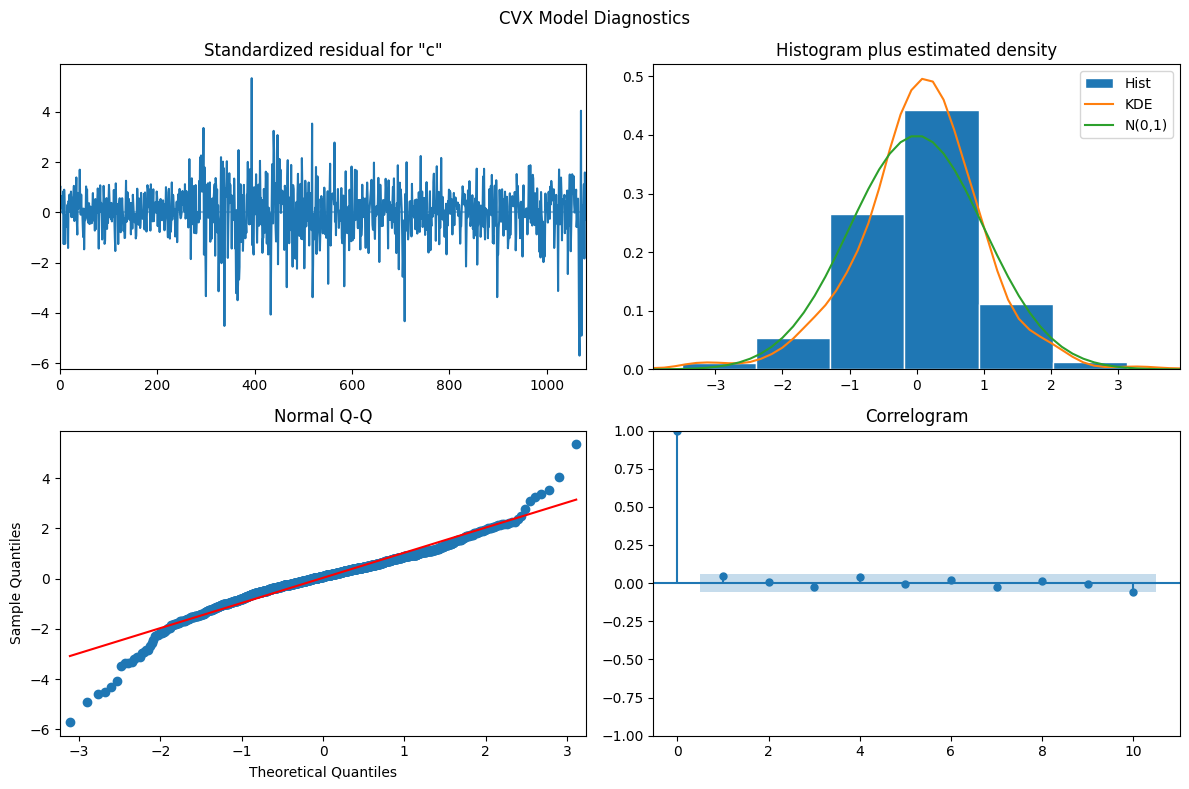

In [51]:

for ticker in list(tickers_names.keys()):
    df = stock_data[stock_data['ticker']==ticker]['close']

    model = ARIMA(df, order = (0,1,0))
    results = model.fit()
    print(results.summary())

    predict = results.get_forecast(steps = 30)
    last_date = stock_data[stock_data['ticker'] == ticker].index.max()
    predict_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')
    # predict_index = pd.date_range(start = df[-1], periods = 30, freq = 'D')
    predict_mean = predict.predicted_mean
    predict_conf_int = predict.conf_int()

    plt.figure(figsize = (10,5))
    plt.plot(df, label = 'Original')
    plt.plot(predict_index, predict_mean, color = 'red', label = 'Prediction')
    plt.fill_between(predict_index, predict_conf_int.iloc[:,0], predict_conf_int.iloc[:,1], color = 'pink')
    plt.title(f"{ticker} ARIMA Model Forecast")
    plt.xlabel("Date")
    plt.ylabel('Close Price')
    plt.legend()
    plt.savefig(f"plots/predictions/{ticker}_ARIMA_model_forecast.png", dpi=300, bbox_inches='tight') 
    plt.show()

    diag_fig = results.plot_diagnostics(figsize = (12, 8))
    diag_fig.suptitle(f"{ticker} Model Diagnostics")
    plt.tight_layout()
    plt.show()






## Prediction with Train Test Split

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


SHEL Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  866
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1052.254
Date:                Mon, 28 Apr 2025   AIC                           2106.509
Time:                        13:30:10   BIC                           2111.272
Sample:                             0   HQIC                          2108.332
                                - 866                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.6670      0.024     27.883      0.000       0.620       0.714
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               109.66
Prob(Q):                  

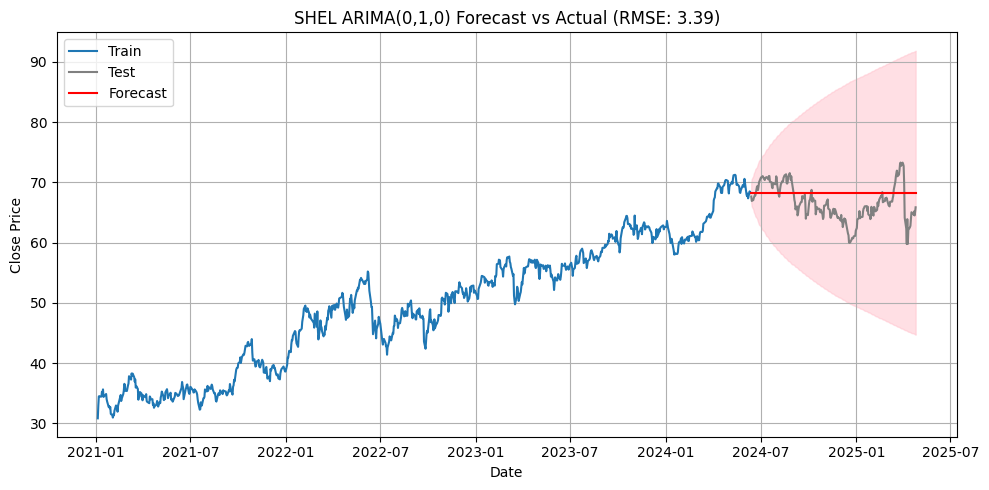

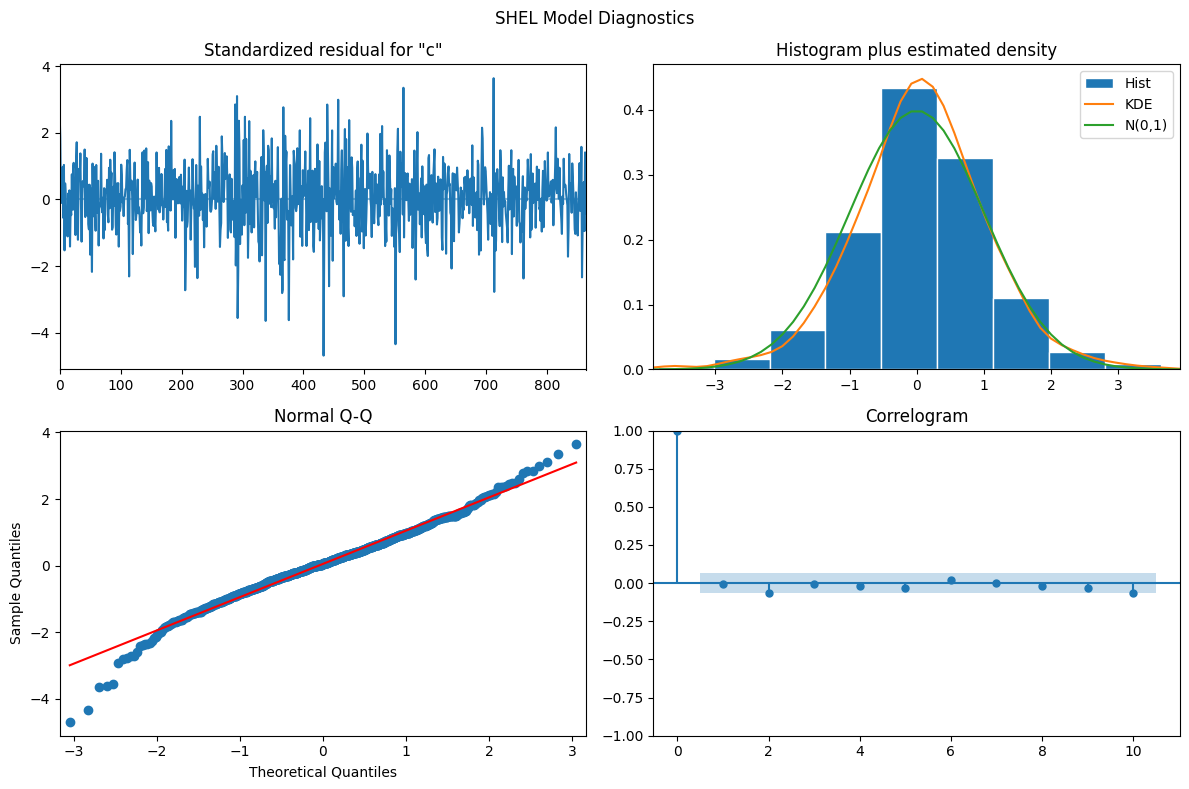

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


XOM Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  866
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1561.036
Date:                Mon, 28 Apr 2025   AIC                           3124.071
Time:                        13:30:12   BIC                           3128.834
Sample:                             0   HQIC                          3125.894
                                - 866                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.1629      0.081     26.757      0.000       2.004       2.321
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):                71.64
Prob(Q):                   

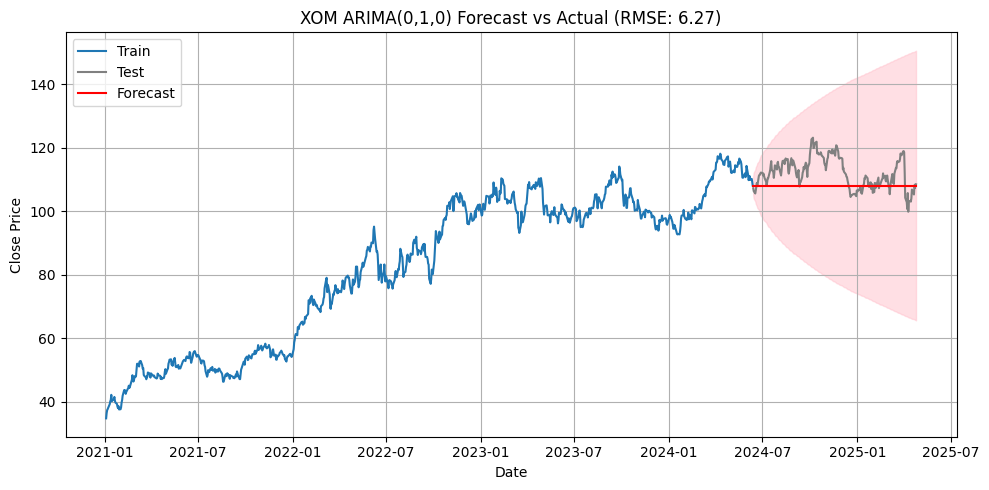

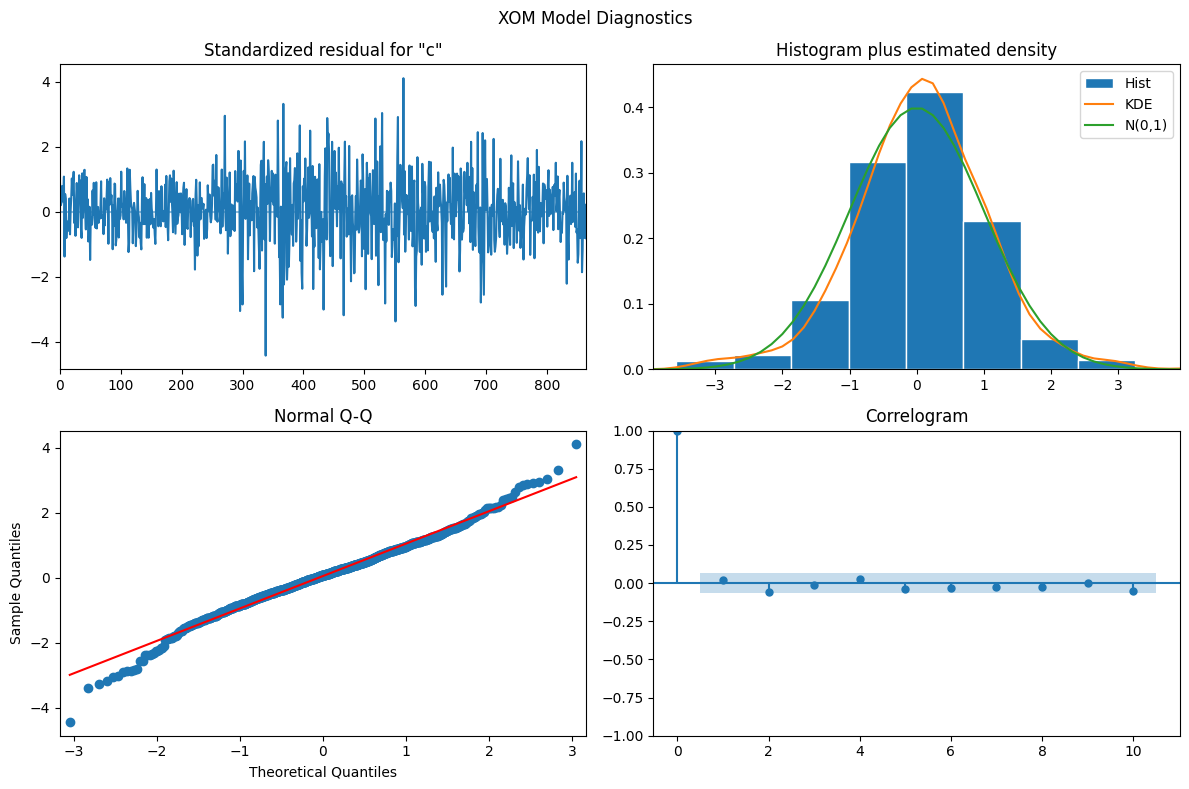

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


BP Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  866
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -648.041
Date:                Mon, 28 Apr 2025   AIC                           1298.081
Time:                        13:30:13   BIC                           1302.844
Sample:                             0   HQIC                          1299.904
                                - 866                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2620      0.008     33.702      0.000       0.247       0.277
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):               403.75
Prob(Q):                    

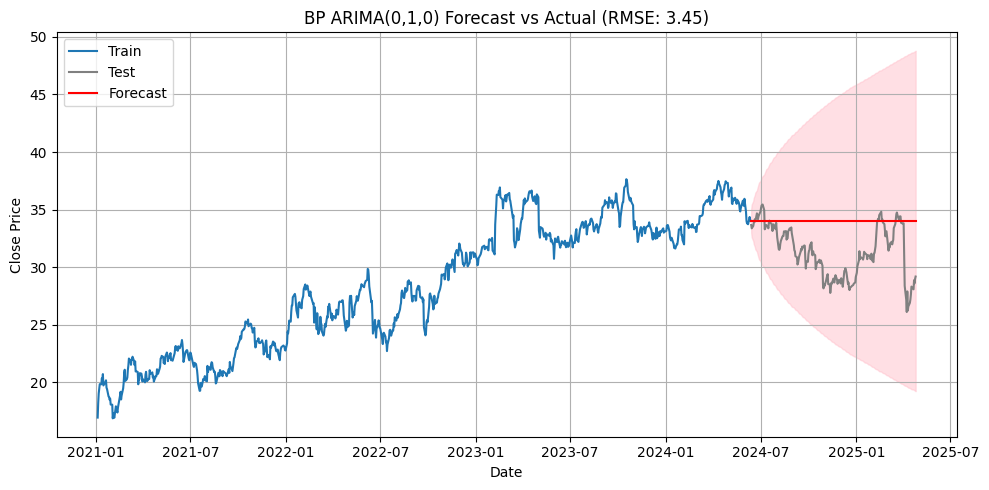

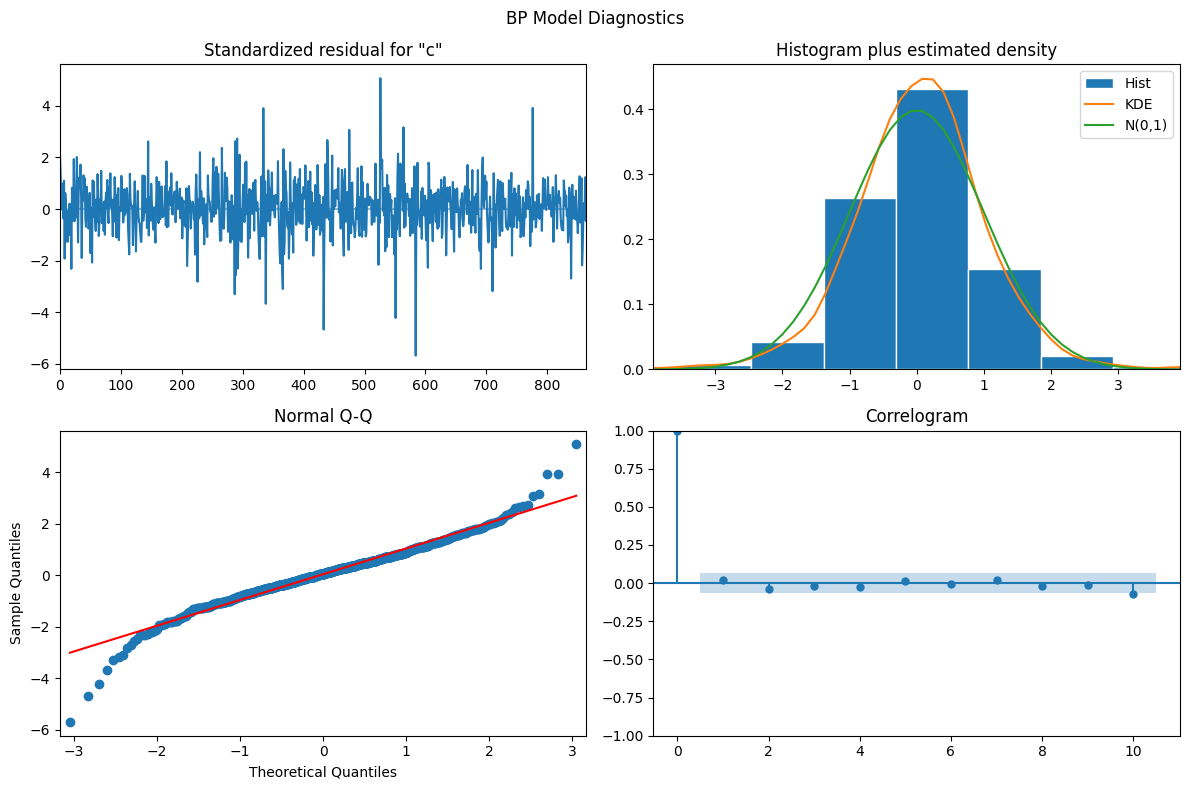

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


CVX Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  866
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1908.347
Date:                Mon, 28 Apr 2025   AIC                           3818.694
Time:                        13:30:15   BIC                           3823.457
Sample:                             0   HQIC                          3820.517
                                - 866                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         4.8282      0.147     32.819      0.000       4.540       5.117
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):               346.40
Prob(Q):                   

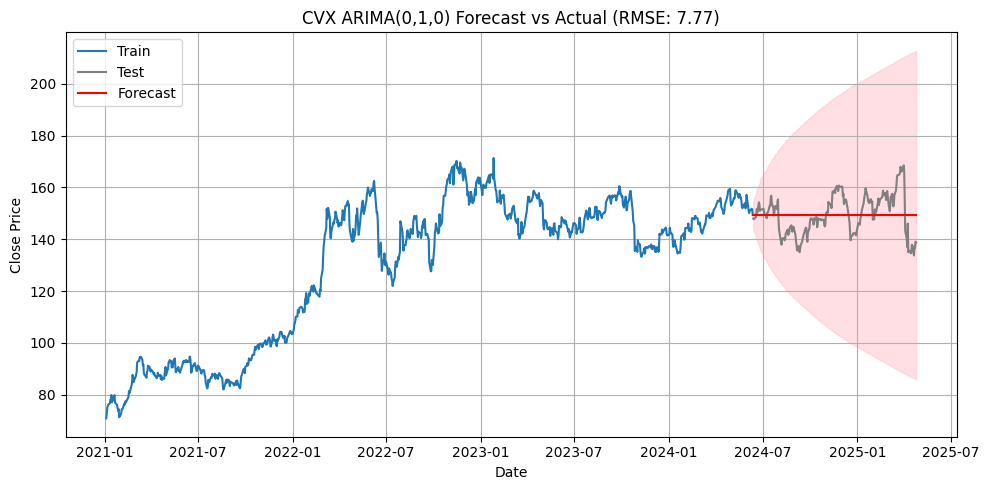

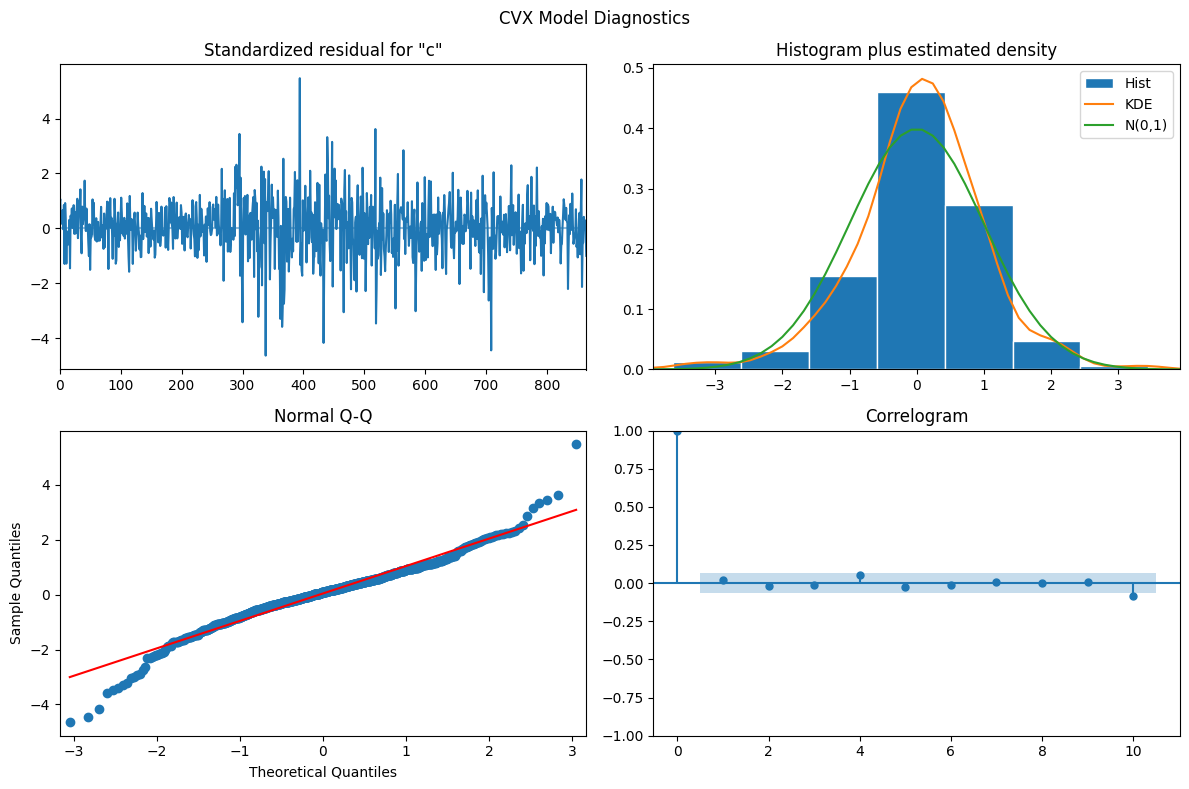

In [52]:
rmse_dict = {}

for ticker in tickers_names.keys():
    df = stock_data[stock_data['ticker'] == ticker]['close'].copy()
    
    # Train-test split (80% train, 20% test)
    split_idx = int(len(df) * 0.8)
    train = df.iloc[:split_idx]
    test = df.iloc[split_idx:]
    
    # Fit ARIMA model on training data
    model = ARIMA(train, order=(0, 1, 0))
    results = model.fit()
    print(f"\n{ticker} Model Summary:")
    print(results.summary())
    
    # Forecast for length of test set
    forecast = results.get_forecast(steps=len(test))
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, forecast_mean))
    rmse_dict[ticker] = rmse
    print(f"{ticker} RMSE on test set: {rmse:.2f}")
    
    # Plot actual vs forecast
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test', color='gray')
    plt.plot(test.index, forecast_mean, label='Forecast', color='red')
    plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.5)
    plt.title(f"{ticker} ARIMA(0,1,0) Forecast vs Actual (RMSE: {rmse:.2f})")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"plots/predictions/{ticker}_arima_model_forecast_vs_actual.png", dpi=300, bbox_inches='tight') 
    plt.show()
    
    # Plot diagnostics
    diag_fig = results.plot_diagnostics(figsize=(12, 8))
    diag_fig.suptitle(f"{ticker} Model Diagnostics")
    plt.tight_layout()
    plt.savefig(f"plots/predictions/{ticker}_model_diagnostics.png", dpi=300, bbox_inches='tight')
    plt.show()

## ARMAX Prediction with Crude Oil Price Data

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


SHEL Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  866
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -909.676
Date:                Mon, 28 Apr 2025   AIC                           1823.353
Time:                        13:30:17   BIC                           1832.878
Sample:                             0   HQIC                          1826.998
                                - 866                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
close          0.2089      0.007     28.177      0.000       0.194       0.223
sigma2         0.4797      0.016     29.873      0.000       0.448       0.511
Ljung-Box (L1) (Q):            

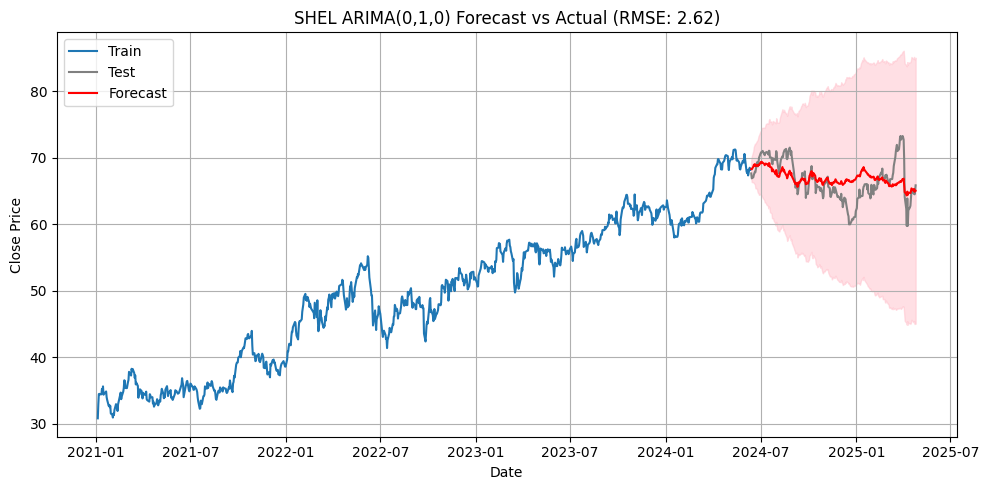

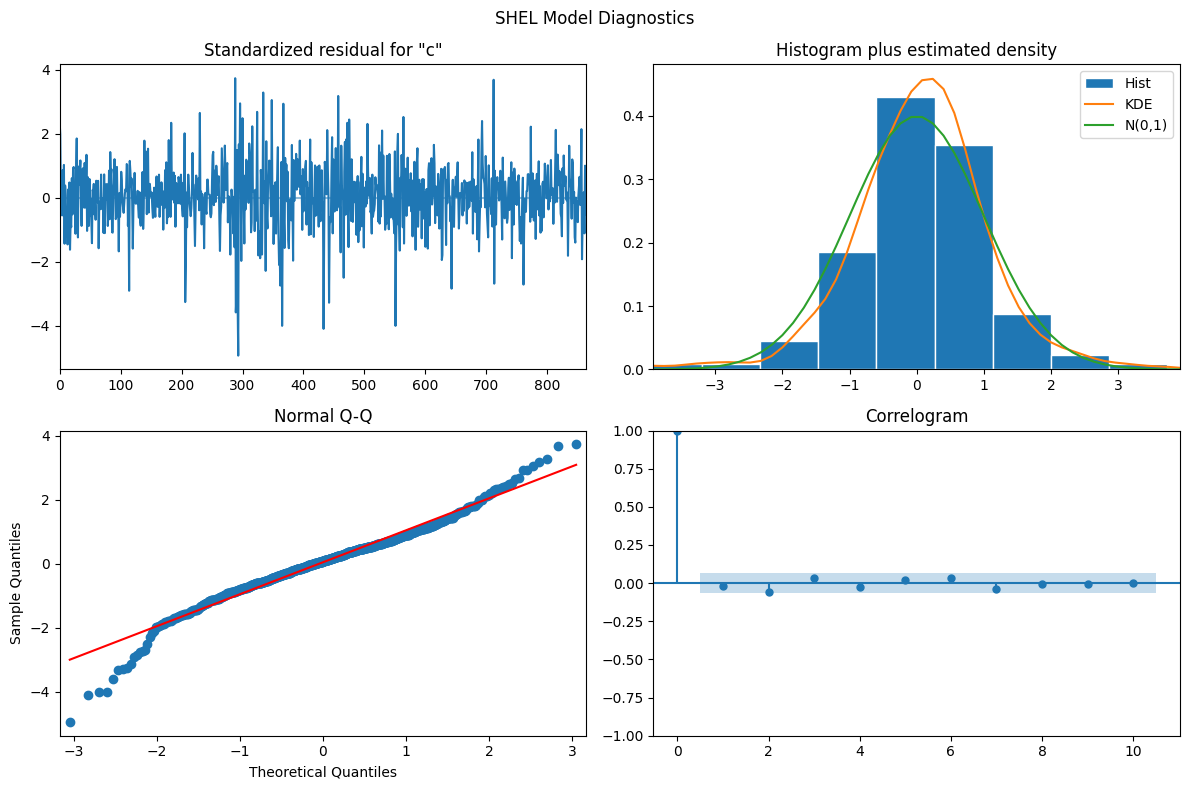

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


XOM Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  866
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1370.160
Date:                Mon, 28 Apr 2025   AIC                           2744.320
Time:                        13:30:18   BIC                           2753.846
Sample:                             0   HQIC                          2747.966
                                - 866                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
close          0.4241      0.015     28.402      0.000       0.395       0.453
sigma2         1.3911      0.052     26.562      0.000       1.288       1.494
Ljung-Box (L1) (Q):             

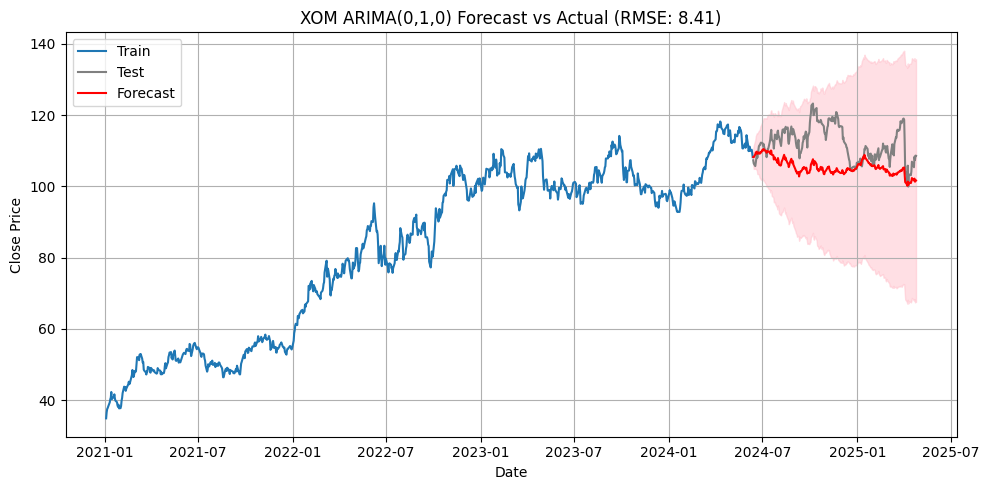

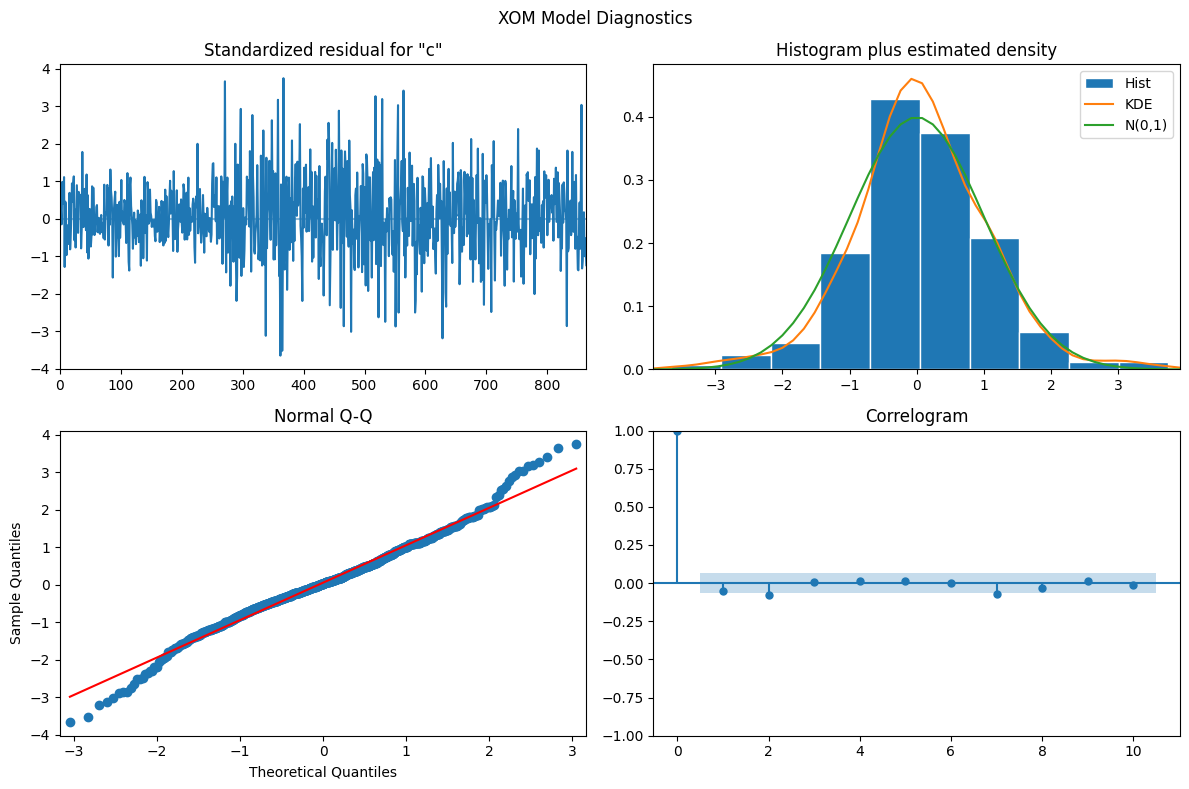

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


BP Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  866
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -508.426
Date:                Mon, 28 Apr 2025   AIC                           1020.851
Time:                        13:30:20   BIC                           1030.377
Sample:                             0   HQIC                          1024.497
                                - 866                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
close          0.1298      0.005     28.208      0.000       0.121       0.139
sigma2         0.1897      0.005     37.742      0.000       0.180       0.200
Ljung-Box (L1) (Q):              

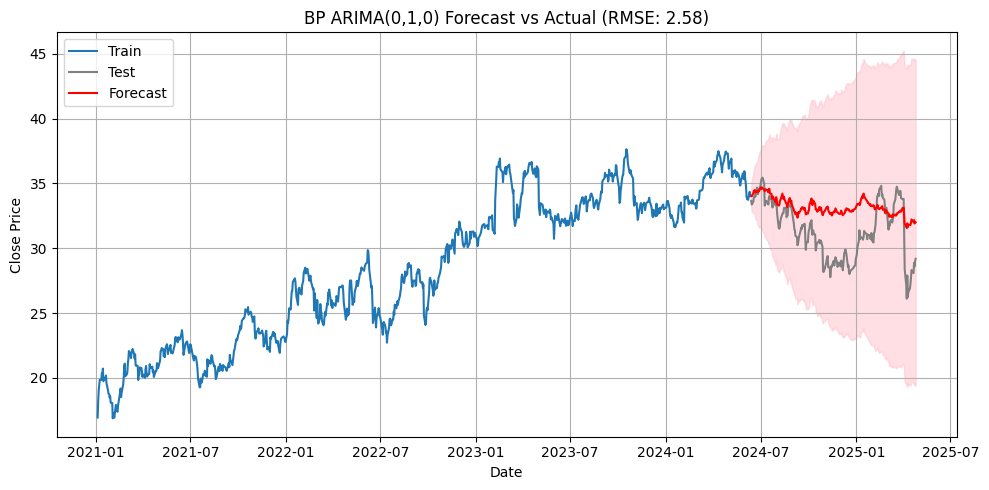

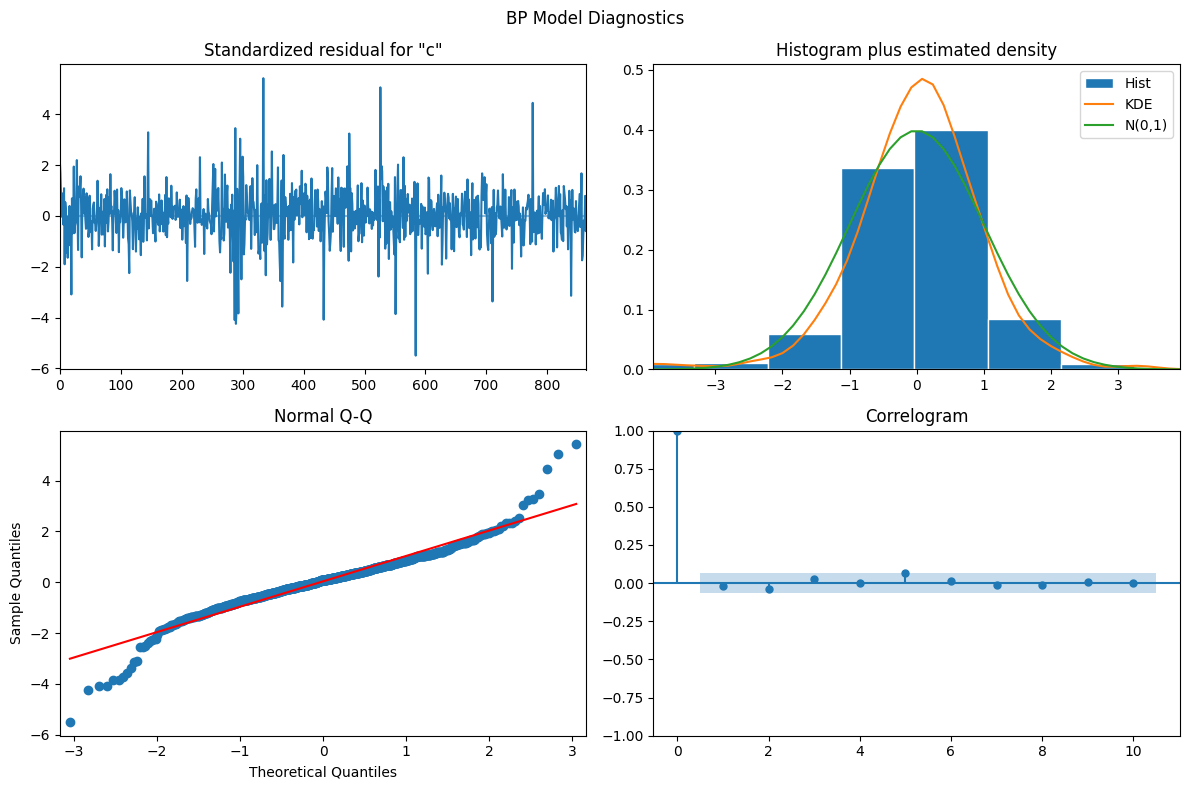

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


CVX Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  866
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1754.779
Date:                Mon, 28 Apr 2025   AIC                           3513.558
Time:                        13:30:22   BIC                           3523.084
Sample:                             0   HQIC                          3517.204
                                - 866                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
close          0.5799      0.022     26.463      0.000       0.537       0.623
sigma2         3.3852      0.089     37.857      0.000       3.210       3.560
Ljung-Box (L1) (Q):             

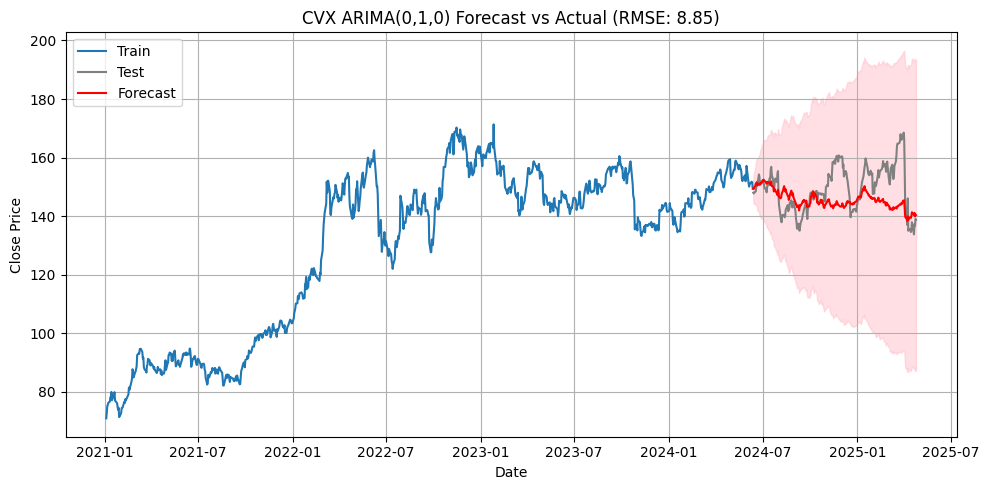

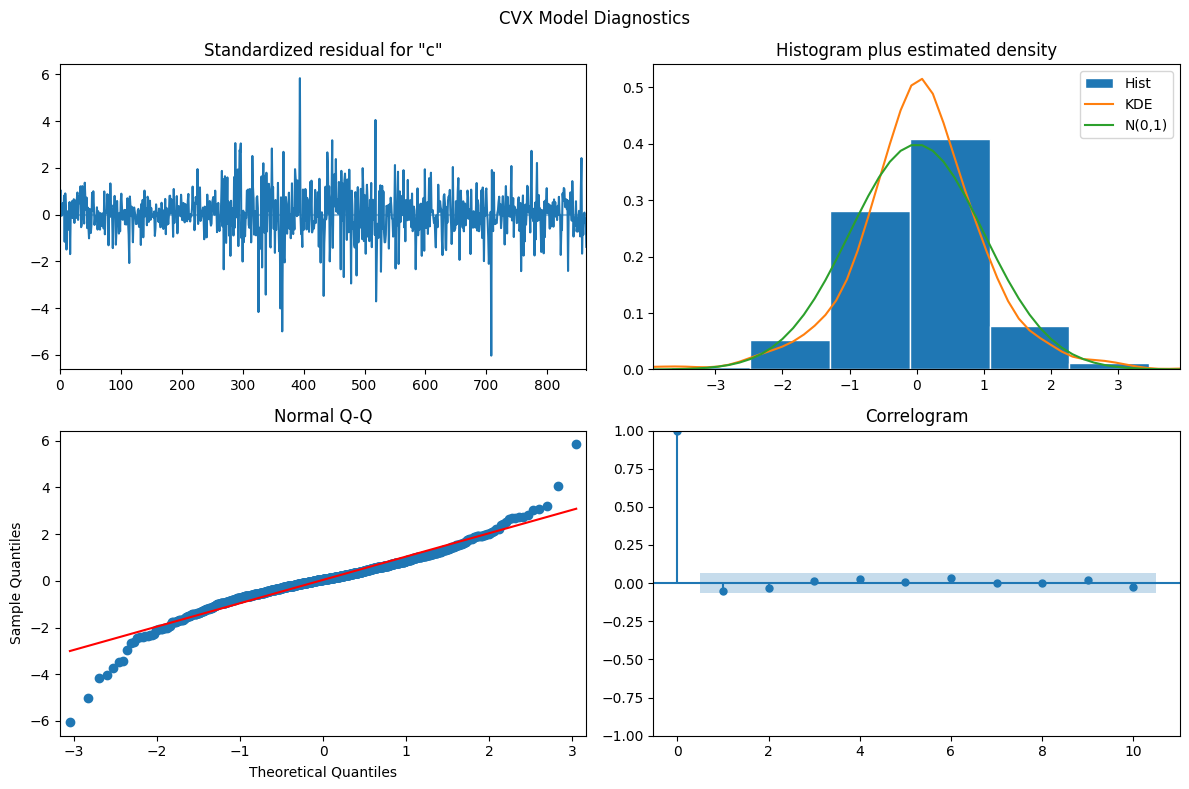

In [53]:
rmse_oil_dict =  {}

for ticker in tickers_names.keys():
    df = stock_data[stock_data['ticker'] == ticker]['close'].copy()
    
    # Train-test split (80% train, 20% test)
    split_idx = int(len(df) * 0.8)
    train = df.iloc[:split_idx]
    test = df.iloc[split_idx:]
    
    # Fit ARIMA model on training data
    oil_df = stock_data[stock_data['ticker']=='CL=F']['close']
    # Reindex oil prices to match the current ticker's index
    oil_df = oil_df.reindex(df.index)
    oil_train = oil_df.iloc[:split_idx]
    oil_test = oil_df.iloc[split_idx:]
    model = ARIMA(train, order=(0, 1, 0), exog= oil_train)
    results = model.fit()
    print(f"\n{ticker} Model Summary:")
    print(results.summary())
    
    # Forecast for length of test set
    forecast = results.get_forecast(steps=len(test), exog=oil_test)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, forecast_mean))
    rmse_oil_dict[ticker] = rmse
    print(f"{ticker} RMSE on test set: {rmse:.2f}")
    
    # Plot actual vs forecast
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test', color='gray')
    plt.plot(test.index, forecast_mean, label='Forecast', color='red')
    plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.5)
    plt.title(f"{ticker} ARIMA(0,1,0) Forecast vs Actual (RMSE: {rmse:.2f})")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"plots/predictions/{ticker}_arima_model_with_crude_oil_price.png", dpi=300, bbox_inches='tight') 
    plt.show()
    
    # Plot diagnostics
    diag_fig = results.plot_diagnostics(figsize=(12, 8))
    diag_fig.suptitle(f"{ticker} Model Diagnostics")
    plt.tight_layout()
    plt.savefig(f"plots/predictions/{ticker}_model_with_oil_diagnostics.png", dpi=300, bbox_inches='tight')
    plt.show()

In [54]:
print(rmse_dict)
print(rmse_oil_dict)

{'SHEL': np.float64(3.3863464795880267), 'XOM': np.float64(6.2682995126713426), 'BP': np.float64(3.4461553714472593), 'CVX': np.float64(7.767311692158018)}
{'SHEL': np.float64(2.6168535946487146), 'XOM': np.float64(8.408784441396852), 'BP': np.float64(2.5845673152091195), 'CVX': np.float64(8.846833871387014)}


## ARMAX Prediction with Natural Gas Data


SHEL Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  866
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1044.014
Date:                Mon, 28 Apr 2025   AIC                           2092.028
Time:                        13:30:24   BIC                           2101.553
Sample:                             0   HQIC                          2095.674
                                - 866                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
close          0.4654      0.107      4.351      0.000       0.256       0.675
sigma2         0.6544      0.024     27.367      0.000       0.608       0.701
Ljung-Box (L1) (Q):            

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

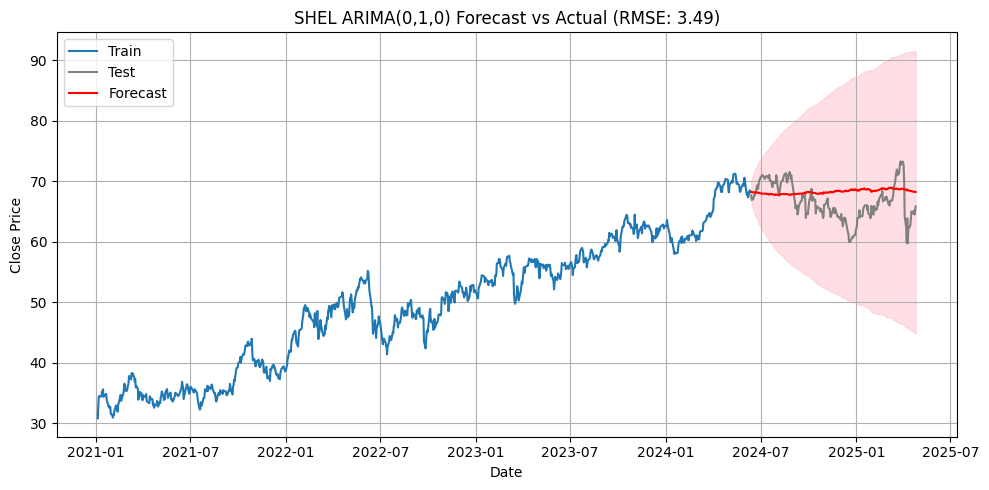

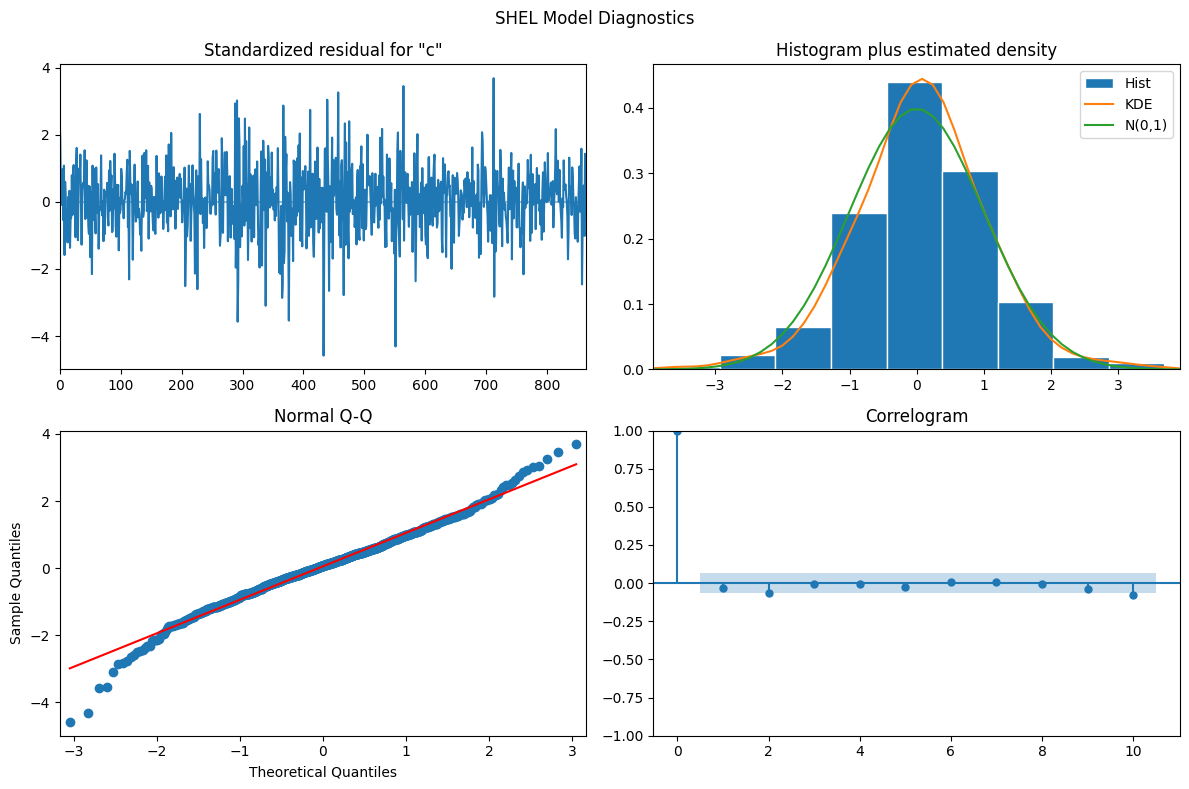

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


XOM Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  866
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1548.492
Date:                Mon, 28 Apr 2025   AIC                           3100.984
Time:                        13:30:25   BIC                           3110.509
Sample:                             0   HQIC                          3104.629
                                - 866                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
close          1.0314      0.177      5.841      0.000       0.685       1.377
sigma2         2.1011      0.081     26.018      0.000       1.943       2.259
Ljung-Box (L1) (Q):             

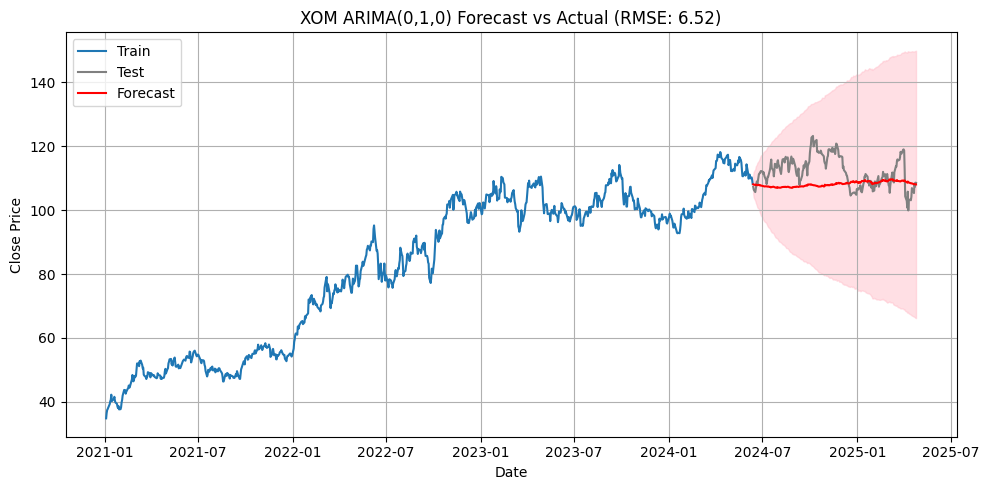

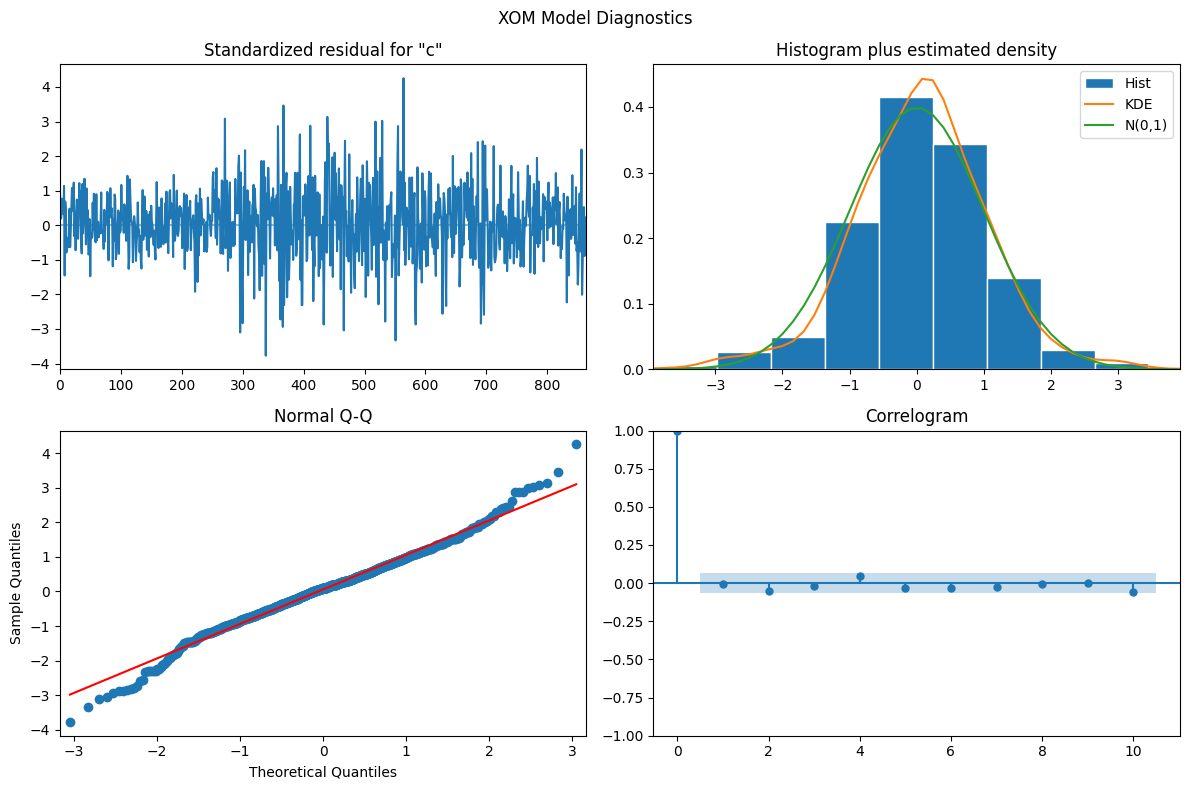

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


BP Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  866
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -640.126
Date:                Mon, 28 Apr 2025   AIC                           1284.252
Time:                        13:30:28   BIC                           1293.778
Sample:                             0   HQIC                          1287.898
                                - 866                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
close          0.2859      0.072      3.977      0.000       0.145       0.427
sigma2         0.2572      0.008     32.749      0.000       0.242       0.273
Ljung-Box (L1) (Q):              

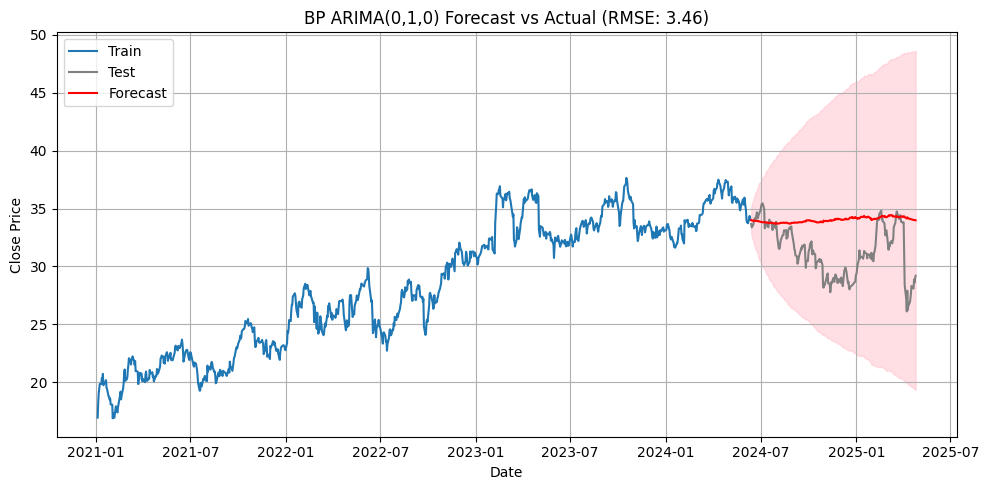

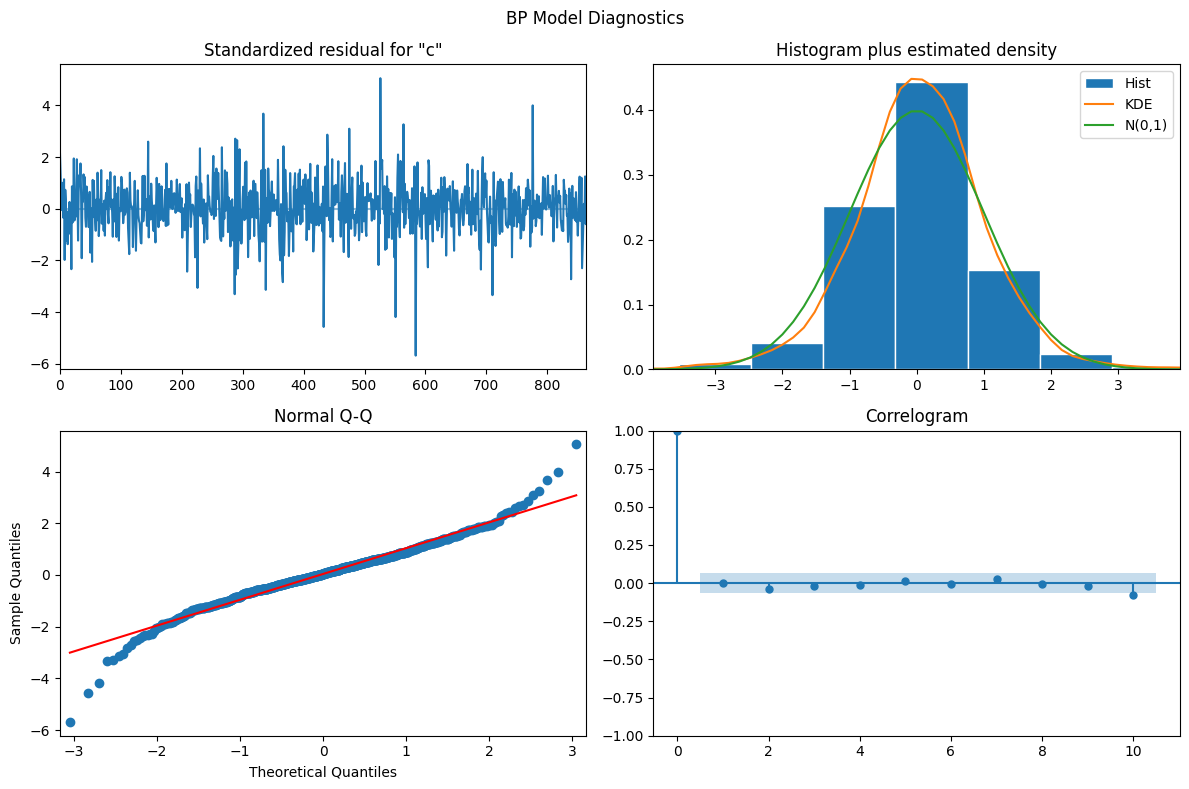

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta


CVX Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  866
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1894.607
Date:                Mon, 28 Apr 2025   AIC                           3793.214
Time:                        13:30:29   BIC                           3802.740
Sample:                             0   HQIC                          3796.860
                                - 866                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
close          1.6116      0.264      6.103      0.000       1.094       2.129
sigma2         4.6773      0.144     32.524      0.000       4.395       4.959
Ljung-Box (L1) (Q):             

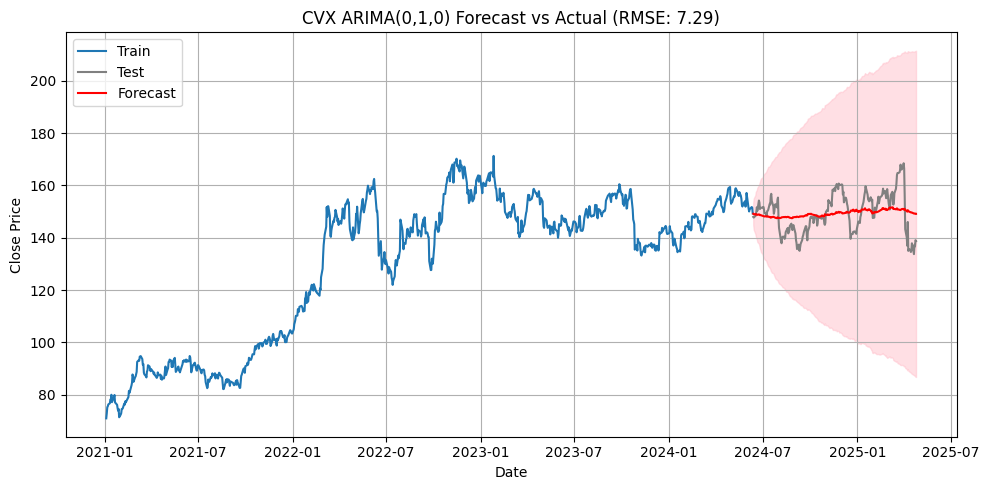

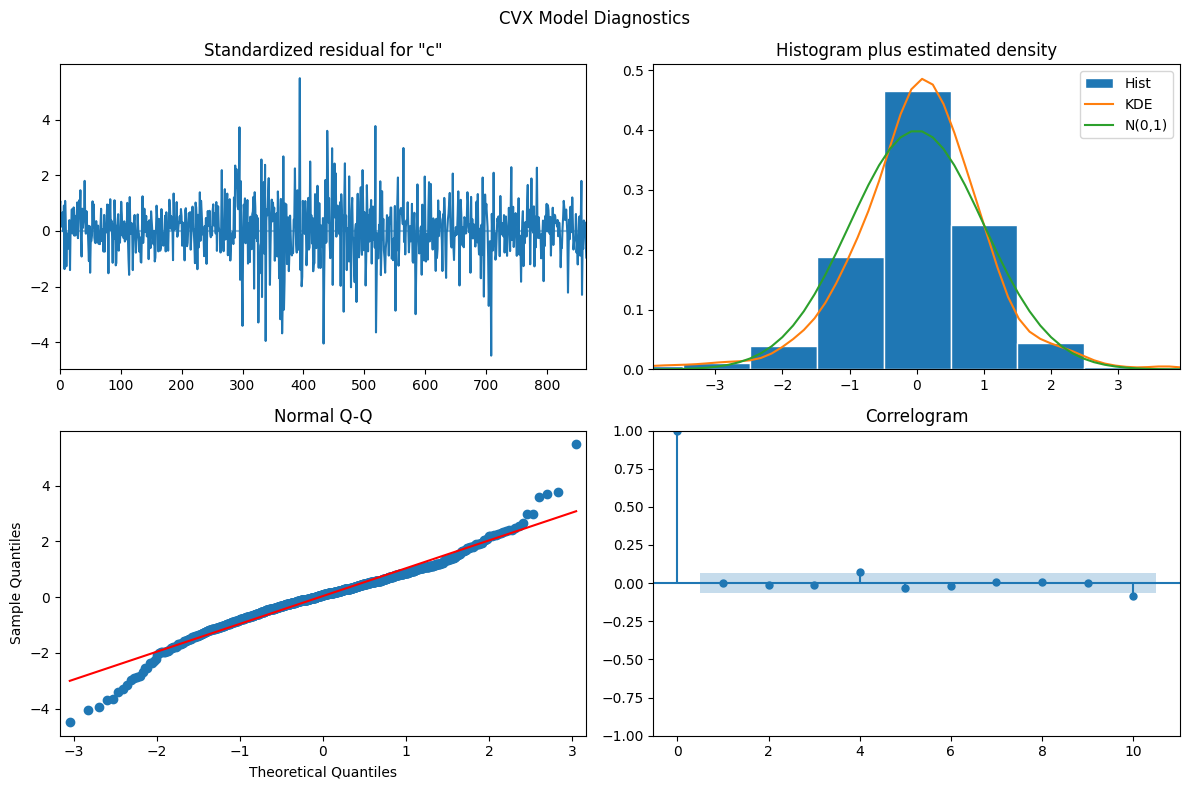

In [55]:
rmse_gas_dict = {}

for ticker in tickers_names.keys():
    df = stock_data[stock_data['ticker'] == ticker]['close'].copy()
    
    # Train-test split (80% train, 20% test)
    split_idx = int(len(df) * 0.8)
    train = df.iloc[:split_idx]
    test = df.iloc[split_idx:]
    
    # Fit ARIMA model on training data
    oil_df = stock_data[stock_data['ticker']=='NG=F']['close']
    # Reindex oil prices to match the current ticker's index
    oil_df = oil_df.reindex(df.index)
    oil_train = oil_df.iloc[:split_idx]
    oil_test = oil_df.iloc[split_idx:]
    model = ARIMA(train, order=(0, 1, 0), exog= oil_train)
    results = model.fit()
    print(f"\n{ticker} Model Summary:")
    print(results.summary())
    
    # Forecast for length of test set
    forecast = results.get_forecast(steps=len(test), exog=oil_test)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, forecast_mean))
    rmse_gas_dict[ticker] = rmse
    print(f"{ticker} RMSE on test set: {rmse:.2f}")
    
    # Plot actual vs forecast
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test', color='gray')
    plt.plot(test.index, forecast_mean, label='Forecast', color='red')
    plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.5)
    plt.title(f"{ticker} ARIMA(0,1,0) Forecast vs Actual (RMSE: {rmse:.2f})")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"plots/predictions/{ticker}_arima_model_with_natural_gas_price.png", dpi=300, bbox_inches='tight') 
    plt.show()
    
    # Plot diagnostics
    diag_fig = results.plot_diagnostics(figsize=(12, 8))
    diag_fig.suptitle(f"{ticker} Model Diagnostics")
    plt.tight_layout()
    plt.savefig(f"plots/predictions/{ticker}_model_with_gas_diagnostics.png", dpi=300, bbox_inches='tight')
    plt.show()

## Model Comparison

In [56]:
rmse_comparison_df = pd.DataFrame({
    'ARIMA': rmse_dict,
    'ARIMA + Crude Oil': rmse_oil_dict,
    'ARIMA + Natural Gas': rmse_gas_dict
})

rmse_comparison_df = rmse_comparison_df.round(3)
print(rmse_comparison_df)

      ARIMA  ARIMA + Crude Oil  ARIMA + Natural Gas
SHEL  3.386              2.617                3.487
XOM   6.268              8.409                6.518
BP    3.446              2.585                3.464
CVX   7.767              8.847                7.287
